In [32]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns
import anndata

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

In [14]:
import time

time.sleep(60)
sup=5

In [15]:
sup

5

In [16]:
device = 'cuda'
# device = 'cpu'

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## define helper functions

In [18]:
# define a function to gather positions
def get_pos(n_x, n_y):
    # create the hex lattice
    xs = np.array([np.arange(0, n_x) + 0.5 if idx % 2 == 0 else np.arange(0, n_x) for idx in range(n_y)])
    # derive the y-step given a distance of one
    y_step = np.sqrt(1**2+0.5**2)
    ys = np.array([[y_step * idy] * n_x for idy in range(n_y)])
    # define the positions
    pos = np.vstack([xs.flatten(), ys.flatten()]).T
    return pos

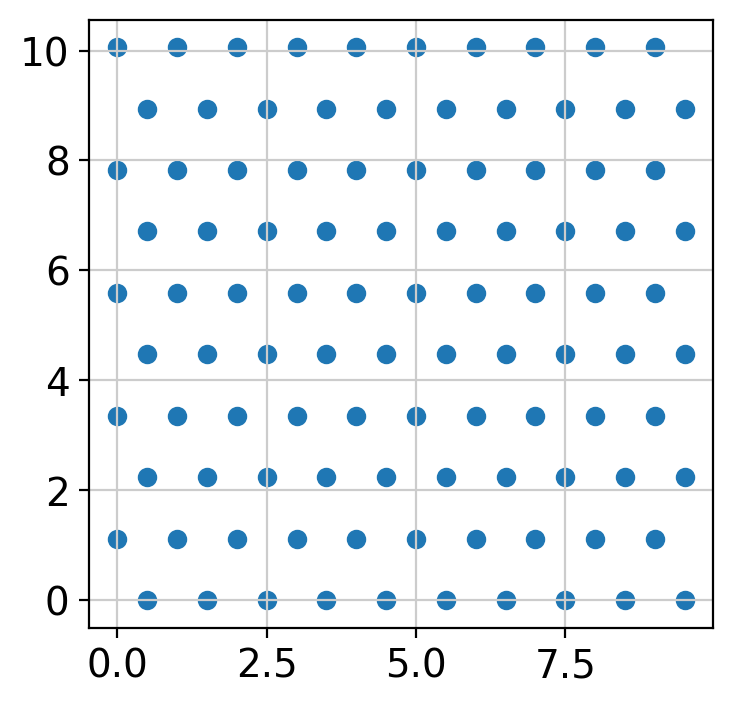

In [19]:
pos = get_pos(10, 10)
plt.scatter( pos[:,0], pos[:,1])

In [20]:
# define a function to derive the gex from the sphex
def calc_gex(sphex):
    """
    Calculates the gene expression matrix from the spherical
    """
    # setup the gex
    n_genes = sphex.shape[1]+1
    gex = torch.from_numpy(np.ones((sphex.shape[0], n_genes)).astype('float32')).to(device)
    # compute the gex
    for idx in range(n_genes):
        for idx_ in range(idx):
            gex[:,idx] *= torch.sin(sphex[:,idx_])
        if idx < n_genes-1:
            gex[:,idx] *= torch.cos(sphex[:,idx])
    return torch.nan_to_num(gex).to(device)

In [21]:
from torch_geometric.nn import GCNConv
from sklearn.neighbors import kneighbors_graph
# define the number of neighbors (six for visium)
n_neighbors = 6
# define the simcomen class
class simcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(simcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.sphex = None
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=False)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(n_genes).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=False)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_sphex(self, sphex):
        """
        Artifically sets the current sphex matrix
        """
        self.sphex = torch.nn.Parameter(sphex, requires_grad=True)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the gex
        self.gex = calc_gex(self.sphex)
        # print
        # print(f"device of self.gex is {self.gex.get_device()}")
        # print(f"device of edge_index is {edge_index.get_device()}")
        edge_index = edge_index.to(device)
        # print(f"device of edge_index is {edge_index.get_device()}")
        # print(f"device of model is {self.get_device()}")
        
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [22]:
# define the celcomen class
class celcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(celcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=True)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g)).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=True)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_gex(self, gex):
        """
        Artifically sets the current sphex matrix
        """
        self.gex = torch.nn.Parameter(gex, requires_grad=False)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [23]:
# define a function to normalize the g2g
def normalize_g2g(g2g):
    """
    Addresses any small fluctuations in symmetrical weights
    """
    # symmetrize the values
    g2g = (g2g + g2g.T) / 2
    # force them to be between 0-1
    g2g[g2g < 0] = 0
    g2g[g2g > 1] = 1
    # force the central line to be 1
    for idx in range(len(g2g)):
        g2g[idx, idx] = 1
    return g2g

## perform simulations

In [24]:
# jump start loss0


# def run_scc(input_g2g, params, plot=False):
#     # define the hyperparameters
#     n_x, n_y, n_genes = params[:3]
#     learning_rate = params[3]
#     zmft_scalar = params[4]
#     seed = params[5]
#     epochs = params[6]
#     # instantiate the model, input and output will be the same
#     model = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
    
#     # now perform the simulation
#     np.random.seed(seed)
#     # retrieve the positions
#     pos = torch.from_numpy(get_pos(n_x, n_y).astype('float32'))
#     # find the edges via kneighbors, not including self because we are considering intercellular
#     edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
#     edge_index = torch.from_numpy(np.array(np.where(edge_index)))
#     # artifically set the g2g matrix
#     model.set_g2g(input_g2g)
#     model.set_g2g_intra(input_g2g)

#     # initialize a gene expression matrix
#     input_sphex = np.random.normal(np.pi/4, np.pi/8, size=(pos.shape[0], n_genes-1)).astype('float32')
#     model.set_sphex(torch.from_numpy(input_sphex.copy()))

#     # move to device
#     model.to(device)
#     # train the model
#     model.train()

#     # keep changing the initialization until you have a good starting point
#     loss0 = 2000
#     while loss0>200:
#         msg, msg_intra, log_z_mft = model(edge_index, 1)
#         loss0 = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
#         input_sphex = np.random.normal(np.pi/4, np.pi/8, size=(pos.shape[0], n_genes-1)).astype('float32')
#         model.set_sphex(torch.from_numpy(input_sphex.copy()))
#         model.to(device)
#         model.train()
            
#     # set up the optimizer
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
#     # keep track of the losses per data object
#     loss, losses = None, []

#     # work through epochs
#     for epoch in range(epochs):
#         # derive the message as well as the mean field approximation
#         msg, msg_intra, log_z_mft = model(edge_index, 1)
#         if epoch == 0:
#             input_gex, input_msg = model.gex.clone().detach().cpu().numpy(), msg.clone().detach().cpu().numpy()
#         # compute the loss and track it
#         loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
#         losses.append(loss.detach().cpu().numpy()[0][0])
#         # derive the gradients, update, and clear
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

    
    
#     # create the plot
#     if plot:
#         fig, ax = plt.subplots(figsize=[6, 4])
#         ax.grid(False)
#         ax.plot(losses, lw=2, color='#fe86a4')
#         ax.set_xlim(0, epochs)
#         vmin, vmax = min(min(losses), 0), max(losses)
#         vstep = (vmax - vmin) * 0.01
#         ax.set_ylim(vmin-vstep, vmax+vstep)
#         ax.set(xlabel='epochs', ylabel='loss')
    
#     # retrieve the data
#     output_gex = model.gex.detach().cpu().numpy()
#     output_msg = msg.detach().cpu().numpy()
#     exp_g2g = input_g2g.detach().cpu().numpy()
#     # plot the correlations
#     if plot:
#         for matrix in [input_gex, input_msg, output_gex, output_msg]:
#             g = sns.clustermap(pd.DataFrame(matrix).corr(method='spearman'), cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
#                                figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
#             g.ax_heatmap.grid(False)
#             g.ax_cbar.grid(False)
#             g.ax_heatmap.tick_params(labelrotation=0)
#         # plot the expected g2g matrix
#         g = sns.clustermap(exp_g2g, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
#                            figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
#         g.ax_heatmap.grid(False)
#         g.ax_cbar.grid(False)
#         g.ax_heatmap.tick_params(labelrotation=0)
        
#     return losses, input_gex, output_gex, exp_g2g

In [25]:
# jump start by looking at entire loss history


# def run_scc(input_g2g, params, plot=False):
#     # define the hyperparameters
#     n_x, n_y, n_genes = params[:3]
#     learning_rate = params[3]
#     zmft_scalar = params[4]
#     seed = params[5]
#     epochs = params[6]

#     spearman_corr = 0.0

#     while spearman_corr>-0.5:
#         np.random.seed(seed)
#             # instantiate the model, input and output will be the same
#         model = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
        
#         # now perform the simulation
#         # retrieve the positions
#         pos = torch.from_numpy(get_pos(n_x, n_y).astype('float32'))
#         # find the edges via kneighbors, not including self because we are considering intercellular
#         edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
#         edge_index = torch.from_numpy(np.array(np.where(edge_index)))
#         # artifically set the g2g matrix
#         model.set_g2g(input_g2g)
#         model.set_g2g_intra(input_g2g)

#         # initialize a gene expression matrix
#         input_sphex = np.random.normal(np.pi/4, np.pi/8, size=(pos.shape[0], n_genes-1)).astype('float32')
#         model.set_sphex(torch.from_numpy(input_sphex.copy()))
    
#         # move to device
#         model.to(device)
#         # train the model
#         model.train()
    
#         # keep changing the initialization until you have a good starting point
#         # loss0 = 2000
#         # while loss0>200:
#         #     msg, msg_intra, log_z_mft = model(edge_index, 1)
#         #     loss0 = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
#         #     input_sphex = np.random.normal(np.pi/4, np.pi/8, size=(pos.shape[0], n_genes-1)).astype('float32')
#         #     model.set_sphex(torch.from_numpy(input_sphex.copy()))
#         #     model.to(device)
#         #     model.train()
                
#         # set up the optimizer
#         optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
#         # keep track of the losses per data object
#         loss, losses = None, []
    
#         # work through epochs
#         for epoch in range(epochs):
#             # derive the message as well as the mean field approximation
#             msg, msg_intra, log_z_mft = model(edge_index, 1)
#             if epoch == 0:
#                 input_gex, input_msg = model.gex.clone().detach().cpu().numpy(), msg.clone().detach().cpu().numpy()
#             # compute the loss and track it
#             loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
#             losses.append(loss.detach().cpu().numpy()[0][0])
#             # derive the gradients, update, and clear
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
            
#         # create the plot
#         if plot:
#             fig, ax = plt.subplots(figsize=[6, 4])
#             ax.grid(False)
#             ax.plot(losses, lw=2, color='#fe86a4')
#             ax.set_xlim(0, epochs)
#             vmin, vmax = min(min(losses), 0), max(losses)
#             vstep = (vmax - vmin) * 0.01
#             ax.set_ylim(vmin-vstep, vmax+vstep)
#             ax.set(xlabel='epochs', ylabel='loss')

#         spearman_corr, pval = ss.spearmanr( losses, sorted(losses) )
#         print(f"spearman_corr={spearman_corr}")
#         seed += 1 
        
    
#     # retrieve the data
#     output_gex = model.gex.detach().cpu().numpy()
#     output_msg = msg.detach().cpu().numpy()
#     exp_g2g = input_g2g.detach().cpu().numpy()
#     # plot the correlations
#     if plot:
#         for matrix in [input_gex, input_msg, output_gex, output_msg]:
#             g = sns.clustermap(pd.DataFrame(matrix).corr(method='spearman'), cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
#                                figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
#             g.ax_heatmap.grid(False)
#             g.ax_cbar.grid(False)
#             g.ax_heatmap.tick_params(labelrotation=0)
#         # plot the expected g2g matrix
#         g = sns.clustermap(exp_g2g, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
#                            figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
#         g.ax_heatmap.grid(False)
#         g.ax_cbar.grid(False)
#         g.ax_heatmap.tick_params(labelrotation=0)
        
#     return losses, input_gex, output_gex, exp_g2g

In [26]:
# original: NO jump start


def run_scc(input_g2g, params, plot=False):
    # define the hyperparameters
    n_x, n_y, n_genes = params[:3]
    learning_rate = params[3]
    zmft_scalar = params[4]
    seed = params[5]
    epochs = params[6]
    # instantiate the model, input and output will be the same
    model = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
    
    # now perform the simulation
    np.random.seed(seed)
    # retrieve the positions
    pos = torch.from_numpy(get_pos(n_x, n_y).astype('float32'))
    # find the edges via kneighbors, not including self because we are considering intercellular
    edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
    edge_index = torch.from_numpy(np.array(np.where(edge_index)))
    # artifically set the g2g matrix
    model.set_g2g(input_g2g)
    model.set_g2g_intra(input_g2g)

    # initialize a gene expression matrix
    input_sphex = np.random.normal(np.pi/4, np.pi/8, size=(pos.shape[0], n_genes-1)).astype('float32')
    model.set_sphex(torch.from_numpy(input_sphex.copy()))

    # move to device
    model.to(device)
    # train the model
    model.train()
            
    # set up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    # keep track of the losses per data object
    loss, losses = None, []

    # work through epochs
    for epoch in range(epochs):
        # derive the message as well as the mean field approximation
        msg, msg_intra, log_z_mft = model(edge_index, 1)
        if epoch == 0:
            input_gex, input_msg = model.gex.clone().detach().cpu().numpy(), msg.clone().detach().cpu().numpy()
        # compute the loss and track it
        loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
        losses.append(loss.detach().cpu().numpy()[0][0])
        # derive the gradients, update, and clear
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # create the plot
    if plot:
        fig, ax = plt.subplots(figsize=[6, 4])
        ax.grid(False)
        ax.plot(losses, lw=2, color='#fe86a4')
        ax.set_xlim(0, epochs)
        vmin, vmax = min(min(losses), 0), max(losses)
        vstep = (vmax - vmin) * 0.01
        ax.set_ylim(vmin-vstep, vmax+vstep)
        ax.set(xlabel='epochs', ylabel='loss')

    spearman_corr, pval = ss.spearmanr( losses, sorted(losses) )
    print(f"spearman_corr={spearman_corr}")

    # retrieve the data
    output_gex = model.gex.detach().cpu().numpy()
    output_msg = msg.detach().cpu().numpy()
    exp_g2g = input_g2g.detach().cpu().numpy()
    # plot the correlations
    if plot:
        for matrix in [input_gex, input_msg, output_gex, output_msg]:
            g = sns.clustermap(pd.DataFrame(matrix).corr(method='spearman'), cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                               figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
            g.ax_heatmap.grid(False)
            g.ax_cbar.grid(False)
            g.ax_heatmap.tick_params(labelrotation=0)
        # plot the expected g2g matrix
        g = sns.clustermap(exp_g2g, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                           figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
        g.ax_heatmap.grid(False)
        g.ax_cbar.grid(False)
        g.ax_heatmap.tick_params(labelrotation=0)
        
    return losses, input_gex, output_gex, exp_g2g

In [27]:
def run_ccc_from_scc(output_gex, params, plot=False):
    # define the hyperparameters
    n_x, n_y, n_genes = params[:3]
    learning_rate = params[3]
    zmft_scalar = params[4]
    seed = params[5]
    epochs = params[6]
    
    # retrieve the positions
    pos = torch.from_numpy(get_pos(n_x, n_y).astype('float32'))
    # find the edges via kneighbors, not including self because we are considering intercellular
    edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
    edge_index = torch.from_numpy(np.array(np.where(edge_index)))
    edge_index = edge_index.to(device)
    
    # instantiate the model, input and output will be the same
    model_rev = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
    
    # now perform the simulation
    np.random.seed(seed)
    # artifically set the g2g matrix
    input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
    input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)
    model_rev.set_g2g(torch.from_numpy(input_g2g))
    model_rev.set_g2g_intra(torch.from_numpy(input_g2g))
    # initialize a gene expression matrix
    model_rev.set_gex(torch.from_numpy(output_gex))
    
    # setup the initial optimizer
    optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
    # keep track of the losses per data object
    loss, losses = None, []
    # train the model
    model_rev.train()
    model_rev.to(device)
    
    # work through epochs
    for epoch in range(epochs):
        # derive the message as well as the mean field approximation
        msg, msg_intra, log_z_mft = model_rev(edge_index, 1)
        # compute the loss and track it
        loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model_rev.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model_rev.gex))) )
        losses.append(loss.detach().cpu().numpy()[0][0])
        # derive the gradients, update, and clear
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # repeatedly force a normalization
        model_rev.conv1.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.conv1.lin.weight), requires_grad=True)
        model_rev.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.lin.weight), requires_grad=True)
        optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
        
    # create the plot
    if plot:
        fig, ax = plt.subplots(figsize=[6, 4])
        ax.grid(False)
        ax.plot(losses, lw=2, color='#fe86a4')
        ax.set_xlim(0, epochs)
        vmin, vmax = min(min(losses), 0), max(losses)
        vstep = (vmax - vmin) * 0.01
        ax.set_ylim(vmin-vstep, vmax+vstep)
        ax.set(xlabel='epochs', ylabel='loss')
    
    # retrieve the data
    obs_g2g_ccc = model_rev.conv1.lin.weight.clone().detach().cpu().numpy()
    if plot:
        g = sns.clustermap(obs_g2g_ccc, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                           figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
        g.ax_heatmap.grid(False)
        g.ax_cbar.grid(False)
        g.ax_heatmap.tick_params(labelrotation=0)
    obs_g2g_intra = model_rev.lin.weight.clone().detach().cpu().numpy()
    if plot:
        g = sns.clustermap(obs_g2g_intra, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                           figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
        g.ax_heatmap.grid(False)
        g.ax_cbar.grid(False)
        g.ax_heatmap.tick_params(labelrotation=0)

    return losses, obs_g2g_ccc, obs_g2g_intra

In [28]:
# define a function to generate a random g2g interaction matrix
def gen_g2g(n_genes):
    # sample the interaction terms and guarantee at least one interaction
    p = ss.uniform.rvs(size=1)[0]
    intrxns = [0]
    # we continously sample until we get interactions that do are not all empty or full
    while (np.mean(intrxns) == 0.0) | (np.mean(intrxns) == 1.0):
        intrxns = ss.binom.rvs(1, p, size=sum(list(range(n_genes))))
    # fill in the input g2g with the appropriate terms
    input_g2g = np.ones((n_genes, n_genes)).astype('float32')
    idz = 0
    for idx in range(n_genes-1):
        for idy in range(idx+1, n_genes):
            input_g2g[idx, idy] = intrxns[idz]
            input_g2g[idy, idx] = intrxns[idz]
            idz += 1
    input_g2g = torch.tensor(input_g2g)
    return input_g2g

In [29]:
def gen_g2g_uni(n_genes):
    # sample the interaction terms and guarantee at least one interaction
    # intrxns = ss.randint.rvs(size=sum(list(range(n_genes))))
    intrxns = np.random.randint(0, sum(list(range(n_genes))),size=sum(list(range(n_genes)))   )/sum(list(range(n_genes)))
    # fill in the input g2g with the appropriate terms
    input_g2g = np.ones((n_genes, n_genes)).astype('float32')
    idz = 0
    for idx in range(n_genes-1):
        for idy in range(idx+1, n_genes):
            input_g2g[idx, idy] = intrxns[idz]
            input_g2g[idy, idx] = intrxns[idz]
            idz += 1
    input_g2g = torch.tensor(input_g2g)
    return input_g2g

# gen_g2g_uni(10)

In [71]:
import anndata
n_x, n_y, n_genes = 10, 10, 25
learning_rate = 1e-1
zmft_scalar = 0.01
epochs = 1500
# define the parameters
n_sims = 100
params_list = [[n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs] for seed in list(range(0,100*n_sims, 100) ) ]
params = params_list[0]
params[-2] = 123
input_g2g = gen_g2g_uni(n_genes)
# run the simulation
losses_scc, input_gex, output_gex, exp_g2g = run_scc(input_g2g, params)

# retrieve info for anndata
df = pd.DataFrame(output_gex)
pos = get_pos(n_x, n_y).astype('float32').tolist()

# remove negatives in output_gex
output_gex -= output_gex.min() #[ output_gex<0 ] = 0

# create anndata
adata = anndata.AnnData(X=output_gex)
adata.layers["counts"] = adata.X
adata.obsm["spatial"] = np.array(pos)
adata.obs["total_counts"] = np.sum( adata.X, axis=1 )
                       

print(adata)
print(output_gex[1,:])

spearman_corr=-0.008124426721967433
AnnData object with n_obs × n_vars = 100 × 25
    obs: 'total_counts'
    obsm: 'spatial'
    layers: 'counts'
[0.36152792 1.6835938  0.6691679  0.94352555 1.0621531  1.0492699
 1.0419197  1.0434709  1.0366682  1.034538   0.9996233  0.99968237
 0.99949193 0.99954844 0.9995336  0.9995728  0.9995726  0.99957424
 0.99957556 0.9995756  0.9995756  0.9995756  0.9995756  0.9995756
 0.9995756 ]


In [70]:
output_gex.min()

0.0

In [161]:
import hotspot

hs = hotspot.Hotspot(
    adata,
    layer_key="counts",
    model='danb',
    latent_obsm_key="spatial",
    umi_counts_obs_key="total_counts"
)

In [162]:
hs.create_knn_graph(weighted_graph=False, n_neighbors=6)
hs_results = hs.compute_autocorrelations()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 30340.74it/s]


In [163]:
sum(hs_results.index=="nan"  )    #["C"]


0

In [164]:
hs_results

,C,Z,Pval,FDR
Gene,,,,
1,0.072492,2.609418e-01,0.397069,0.550032
0,0.015016,1.175027e-01,0.453231,0.550032
7,0.018751,3.944902e-02,0.484266,0.550032
13,0.053796,2.142291e-03,0.499145,0.550032
10,0.018001,1.758942e-03,0.499298,0.550032
8,0.001131,1.666193e-03,0.499335,0.550032
12,0.016300,1.255212e-03,0.499499,0.550032
14,0.036343,4.784505e-04,0.499809,0.550032
15,0.002287,1.128143e-05,0.499995,0.550032


In [165]:
hs_genes = hs_results.index # hs_results.loc[hs_results.FDR < 1.1].index # Select genes
print(len(hs_genes))
local_correlations = hs.compute_local_correlations(hs_genes) # jobs for parallelization

50
Computing pair-wise local correlation on 50 features...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 630354.85it/s]


In [166]:
local_correlations

,1,0,7,13,10,8,12,14,15,25,...,19,17,16,11,9,4,6,5,3,2
1,0.000000,-6.118522e-01,1.681437e-01,0.002438,-1.059696e-01,0.429752,0.015086,0.000182,0.002477,-3.768307e-04,...,-0.006458,-0.007134,-0.009762,0.010300,0.108778,-0.183017,-0.333785,0.031058,0.066426,0.004920
0,-0.611852,0.000000e+00,-4.336911e-01,-0.035372,1.129265e-01,-0.502543,-0.049599,-0.020112,-0.010872,-8.239949e-04,...,-0.002399,-0.003925,-0.000919,-0.062566,-0.099190,0.353476,0.123658,0.076891,0.010804,0.200208
7,0.168144,-4.336911e-01,0.000000e+00,-0.028763,-5.053836e-02,0.435313,-0.040012,-0.022951,-0.013017,-1.270035e-03,...,-0.010971,-0.018077,-0.013542,-0.014116,-0.144404,0.070120,-0.267203,-0.136964,0.569393,-0.027245
13,0.002438,-3.537210e-02,-2.876337e-02,0.000000,-1.110519e-02,-0.056543,0.041885,0.052673,0.021770,-2.161697e-03,...,-0.010452,-0.008136,-0.017722,0.025842,-0.046809,0.051953,0.084323,0.008105,0.056287,-0.055858
10,-0.105970,1.129265e-01,-5.053836e-02,-0.011105,0.000000e+00,-0.064244,-0.036428,0.022963,0.011805,-3.019338e-04,...,0.003541,0.003019,0.004733,-0.023847,-0.077327,0.082632,0.039092,-0.088536,-0.014219,-0.037561
8,0.429752,-5.025431e-01,4.353131e-01,-0.056543,-6.424365e-02,0.000000,-0.074864,-0.029442,-0.015110,1.188209e-03,...,-0.000315,-0.006235,-0.004722,-0.069061,-0.128618,-0.135897,-0.109420,-0.343947,0.479312,-0.058079
12,0.015086,-4.959866e-02,-4.001208e-02,0.041885,-3.642837e-02,-0.074864,0.000000,0.053125,0.026458,-2.546978e-03,...,-0.012357,-0.012029,-0.019586,0.001209,-0.081859,0.076166,0.093205,-0.008051,0.056583,-0.061135
14,0.000182,-2.011233e-02,-2.295140e-02,0.052673,2.296319e-02,-0.029442,0.053125,0.000000,0.005734,-1.496061e-03,...,-0.010522,-0.002929,-0.017564,0.041730,-0.015100,0.018250,0.072577,0.033877,0.044093,-0.052378
15,0.002477,-1.087207e-02,-1.301706e-02,0.021770,1.180507e-02,-0.015110,0.026458,0.005734,0.000000,-1.292177e-03,...,-0.008748,-0.003719,-0.007857,0.010893,-0.009132,0.001183,0.041281,0.017186,0.033089,-0.034039
25,-0.000377,-8.239949e-04,-1.270035e-03,-0.002162,-3.019338e-04,0.001188,-0.002547,-0.001496,-0.001292,0.000000e+00,...,-0.000776,-0.001169,-0.000755,-0.002873,0.000971,-0.001554,0.006592,0.004697,0.005346,-0.005683


In [167]:
# local_correlations.values

In [168]:
# local_correlations.to_numpy()

In [169]:
# pos = get_pos(n_x, n_y).astype('float32').tolist()
# pos

plot losses_scc


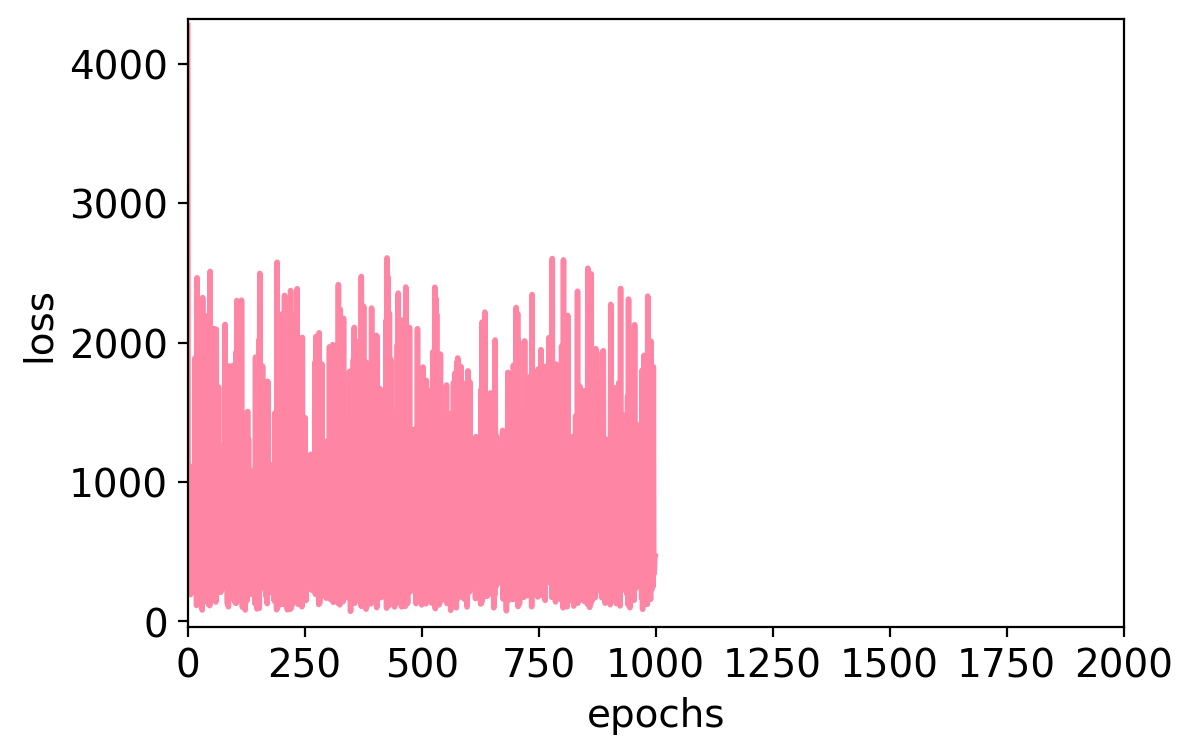

plot losses_ccc


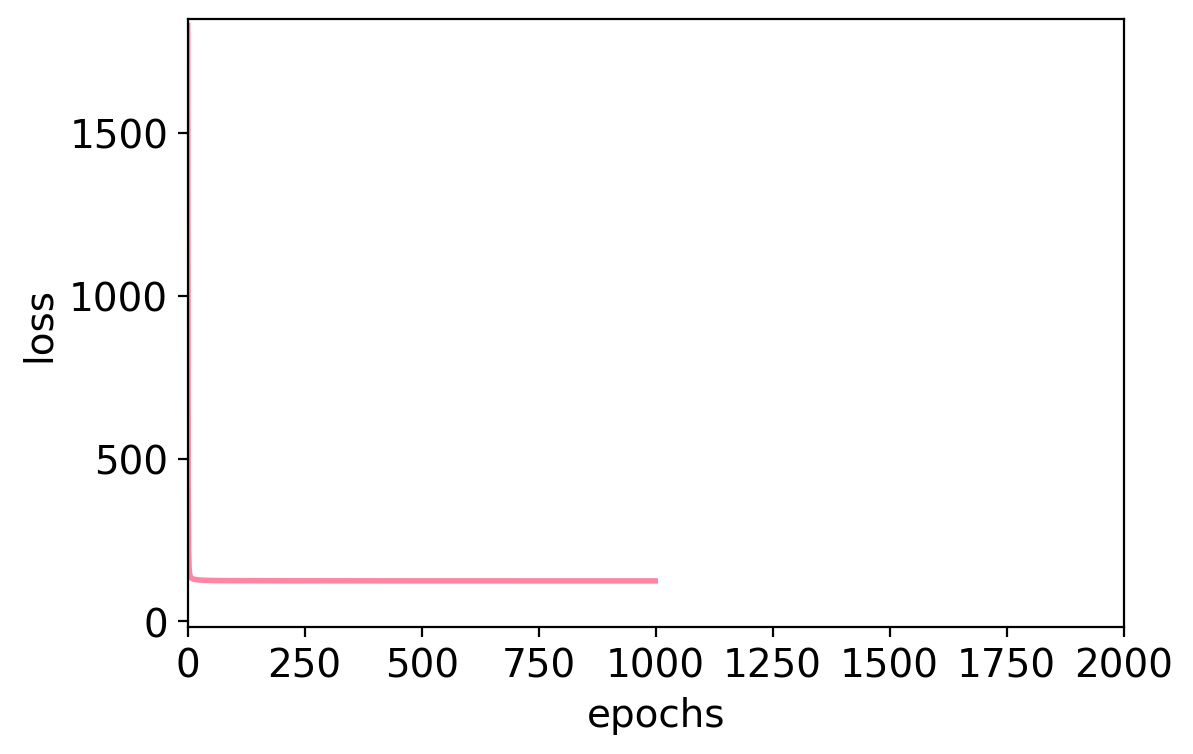

rho=0.05928485316173171
pval=0.003023205127773943
obs_g2g=[[1.   0.   0.   ... 0.   0.   0.  ]
 [0.   1.   0.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.   0.41 0.63]
 [0.   0.   0.   ... 0.41 1.   0.35]
 [0.   0.   0.   ... 0.63 0.35 1.  ]]
exp_g2g=[[1.   0.86 0.21 ... 0.73 0.16 0.34]
 [0.86 1.   0.9  ... 0.39 0.03 0.48]
 [0.21 0.9  1.   ... 0.29 0.59 0.86]
 ...
 [0.73 0.39 0.29 ... 1.   0.96 0.18]
 [0.16 0.03 0.59 ... 0.96 1.   0.31]
 [0.34 0.48 0.86 ... 0.18 0.31 1.  ]]
rho=0.0451346295188264
pval=0.024023519314861977
obs_g2g=[[ 0.   -0.61  0.17 ...  0.03  0.07  0.  ]
 [-0.61  0.   -0.43 ...  0.08  0.01  0.2 ]
 [ 0.17 -0.43  0.   ... -0.14  0.57 -0.03]
 ...
 [ 0.03  0.08 -0.14 ...  0.    0.16  0.44]
 [ 0.07  0.01  0.57 ...  0.16  0.   -0.05]
 [ 0.    0.2  -0.03 ...  0.44 -0.05  0.  ]]
exp_g2g=[[1.   0.86 0.21 ... 0.73 0.16 0.34]
 [0.86 1.   0.9  ... 0.39 0.03 0.48]
 [0.21 0.9  1.   ... 0.29 0.59 0.86]
 ...
 [0.73 0.39 0.29 ... 1.   0.96 0.

In [170]:

print("plot losses_scc")
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses_scc, lw=2, color='#fe86a4')
ax.set_xlim(0, 2000)
vmin, vmax = min(min(losses_scc), 0), max(losses_scc)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')
plt.show()

# define results from ccc
losses_ccc, obs_g2g_ccc, obs_g2g_intra = run_ccc_from_scc(output_gex, params)
obs_g2g = obs_g2g_ccc.copy()
# instantiate a series of the results
results = pd.Series()
results.loc['loss_scc'] = losses_scc[-1]
results.loc['loss_ccc'] = losses_ccc[-1]

print("plot losses_ccc")
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses_ccc, lw=2, color='#fe86a4')
ax.set_xlim(0, 2000)
vmin, vmax = min(min(losses_ccc), 0), max(losses_ccc)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')
plt.show()

# derive the correlation (from ccc)
rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
print(f"rho={rho}")
print(f"pval={pval}")
print(f"obs_g2g={np.round(obs_g2g, 2)}")
print(f"exp_g2g={np.round(exp_g2g,2)}")
results.loc['spearman_ccc_out_vs_scc_in.r'] = rho
results.loc['spearman_ccc_out_vs_scc_in.p'] = pval

# derive the correlation (from hotspot)
rho, pval = ss.spearmanr(local_correlations.to_numpy().flatten(), exp_g2g.flatten())
print(f"rho={rho}")
print(f"pval={pval}")
print(f"obs_g2g={np.round(local_correlations.to_numpy(), 2)}")
print(f"exp_g2g={np.round(exp_g2g,2)}")
results.loc['spearman_hotspot.r'] = rho
results.loc['spearman_hotspot.p'] = pval

In [171]:
results

loss_scc                        468.571075
loss_ccc                        124.725784
spearman_ccc_out_vs_scc_in.r      0.059285
spearman_ccc_out_vs_scc_in.p      0.003023
spearman_hotspot.r                0.045135
spearman_hotspot.p                0.024024
dtype: float32

In [72]:
def run_sim_vs_hotspot(params):
    # unpack the parameters
    n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs = params
    # set the seed
    np.random.seed(seed)
    # define the input g2g
    #input_g2g = gen_g2g(n_genes)
    input_g2g = gen_g2g_uni(n_genes)
    # run the simulation
    losses_scc, input_gex, output_gex, exp_g2g = run_scc(input_g2g, params)
    
    print("plot losses_scc")
    fig, ax = plt.subplots(figsize=[6, 4])
    ax.grid(False)
    ax.plot(losses_scc, lw=2, color='#fe86a4')
    ax.set_xlim(0, 2000)
    vmin, vmax = min(min(losses_scc), 0), max(losses_scc)
    vstep = (vmax - vmin) * 0.01
    ax.set_ylim(vmin-vstep, vmax+vstep)
    ax.set(xlabel='epochs', ylabel='loss')
    plt.show()

    # remove negatives in output_gex
    output_gex -= output_gex.min() #output_gex[ output_gex<0 ] = 0
    
    # create anndata for hotspot
    adata = anndata.AnnData(X=output_gex)
    adata.layers["counts"] = adata.X
    adata.obsm["spatial"] = np.array(pos)
    adata.obs["total_counts"] = np.sum( adata.X, axis=1 )

    # create hotspot object
    hs = hotspot.Hotspot(
        adata,
        layer_key="counts",
        model='danb',
        latent_obsm_key="spatial",
        umi_counts_obs_key="total_counts"
    )

    # run hotspot
    hs.create_knn_graph(weighted_graph=False, n_neighbors=6)
    hs_results = hs.compute_autocorrelations()
    hs_genes = hs_results.index # Select all genes
    local_correlations = hs.compute_local_correlations(hs_genes) 
        

    # define results from ccc
    losses_ccc, obs_g2g_ccc, obs_g2g_intra = run_ccc_from_scc(output_gex, params)
    print(f"output_gex={np.round(output_gex, 2)}")
    obs_g2g = obs_g2g_ccc.copy()
    # instantiate a series of the results
    results = pd.Series()
    results.loc['loss_scc'] = losses_scc[-1]
    results.loc['loss_ccc'] = losses_ccc[-1]

    print("plot losses_ccc")
    fig, ax = plt.subplots(figsize=[6, 4])
    ax.grid(False)
    ax.plot(losses_ccc, lw=2, color='#fe86a4')
    ax.set_xlim(0, 2000)
    vmin, vmax = min(min(losses_ccc), 0), max(losses_ccc)
    vstep = (vmax - vmin) * 0.01
    ax.set_ylim(vmin-vstep, vmax+vstep)
    ax.set(xlabel='epochs', ylabel='loss')
    plt.show()
    
    # derive the correlation (from ccc)
    rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
    rhos_list.append(rho)
    print(f"rho={rho}")
    print(f"pval={pval}")
    print(f"obs_g2g={np.round(obs_g2g, 2)}")
    print(f"exp_g2g={np.round(exp_g2g,2)}")
    results.loc['spearman_ccc_out_vs_scc_in.r'] = rho
    results.loc['spearman_ccc_out_vs_scc_in.p'] = pval
    
    # derive the correlation (correlations of the gex)
    gex_corr = pd.DataFrame(output_gex).corr(method='spearman').values
    rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
    print(f"gex_corr rho={rho}")
    print(f"gex_corr pval={pval}")    
    results.loc['spearman_scc_gex_corr_vs_scc_in.r'] = rho
    results.loc['spearman_scc_gex_corr_vs_scc_in.p'] = pval
    
    # derive the correlation (correlations of the gex)
    gex_corr = pd.DataFrame(input_gex).corr(method='spearman').values
    rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
    print(f"gex_in rho={rho}")
    print(f"gex_in pval={pval}")      
    results.loc['spearman_in_gex_corr_vs_scc_in.r'] = rho
    results.loc['spearman_in_gex_corr_vs_scc_in.p'] = pval

    # derive the correlation (from hotspot)
    rho, pval = ss.spearmanr(local_correlations.to_numpy().flatten(), exp_g2g.flatten())
    print(f"hotspot rho={rho}")
    print(f"hotspot pval={pval}")
    # print(f"obs_g2g={np.round(local_correlations.to_numpy(), 2)}")
    # print(f"exp_g2g={np.round(exp_g2g,2)}")
    results.loc['spearman_hotspot.r'] = rho
    results.loc['spearman_hotspot.p'] = pval
    
    # name it based on the seed
    results.name = f'seed_{seed}'
    results_ccc = results.copy()

    

    # # define results from ccc
    # obs_g2g = obs_g2g_intra.copy()

    # # instantiate a series of the results
    # results = pd.Series()
    # results.loc['loss_scc'] = losses_scc[-1]
    # results.loc['loss_ccc'] = losses_ccc[-1]

    # print("plot losses_ccc")
    # fig, ax = plt.subplots(figsize=[6, 4])
    # ax.grid(False)
    # ax.plot(losses_ccc, lw=2, color='#fe86a4')
    # ax.set_xlim(0, 2000)
    # vmin, vmax = min(min(losses_ccc), 0), max(losses_ccc)
    # vstep = (vmax - vmin) * 0.01
    # ax.set_ylim(vmin-vstep, vmax+vstep)
    # ax.set(xlabel='epochs', ylabel='loss')
    # plt.show()
    
    # # derive the correlation (from ccc)
    # rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
    # rhos_list.append(rho)
    # print(f"rho={rho}")
    # print(f"pval={pval}")
    # # print(f"obs_g2g={np.round(obs_g2g, 2)}")
    # # print(f"exp_g2g={np.round(exp_g2g,2)}")
    # results.loc['spearman_ccc_out_vs_scc_in.r'] = rho
    # results.loc['spearman_ccc_out_vs_scc_in.p'] = pval
    
    # # derive the correlation (correlations of the gex)
    # gex_corr = pd.DataFrame(output_gex).corr(method='spearman').values
    # rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
    # print(f"gex_corr rho={rho}")
    # print(f"gex_corr pval={pval}")    
    # results.loc['spearman_scc_gex_corr_vs_scc_in.r'] = rho
    # results.loc['spearman_scc_gex_corr_vs_scc_in.p'] = pval
    
    # # derive the correlation (correlations of the gex)
    # gex_corr = pd.DataFrame(input_gex).corr(method='spearman').values
    # rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
    # print(f"gex_in rho={rho}")
    # print(f"gex_in pval={pval}")      
    # results.loc['spearman_in_gex_corr_vs_scc_in.r'] = rho
    # results.loc['spearman_in_gex_corr_vs_scc_in.p'] = pval

    # # derive the correlation (from hotspot)
    # rho, pval = ss.spearmanr(local_correlations.to_numpy().flatten(), exp_g2g.flatten())
    # print(f"hotspot rho={rho}")
    # print(f"hotspot pval={pval}")
    # # print(f"obs_g2g={np.round(local_correlations.to_numpy(), 2)}")
    # # print(f"exp_g2g={np.round(exp_g2g,2)}")
    # results.loc['spearman_hotspot.r'] = rho
    # results.loc['spearman_hotspot.p'] = pval
        
    # # name it based on the seed
    # results.name = f'seed_{seed}'
    results_intra = results.copy()
    
    return results_ccc, results_intra

simulation 0; time passed: 4.482269287109375e-05
spearman_corr=0.06425008080341604
plot losses_scc


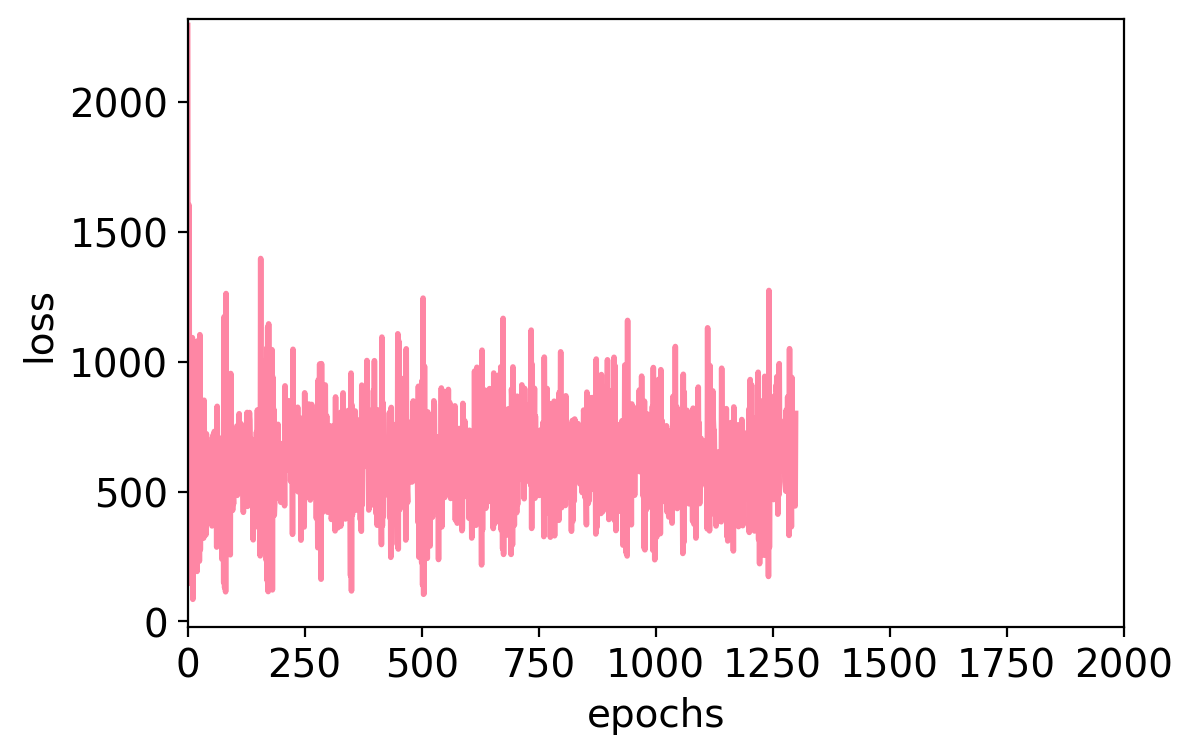

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24350.10it/s]


Computing pair-wise local correlation on 20 features...


100%|████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 458525.75it/s]


output_gex=[[1.   0.   0.99 ... 1.   1.   1.  ]
 [0.26 0.46 0.7  ... 1.   1.   1.  ]
 [0.54 1.37 1.34 ... 1.   1.   1.  ]
 ...
 [0.37 1.53 0.45 ... 1.   1.   1.  ]
 [0.08 0.71 0.87 ... 1.   1.   1.  ]
 [0.14 1.43 0.76 ... 1.   1.   1.  ]]
plot losses_ccc


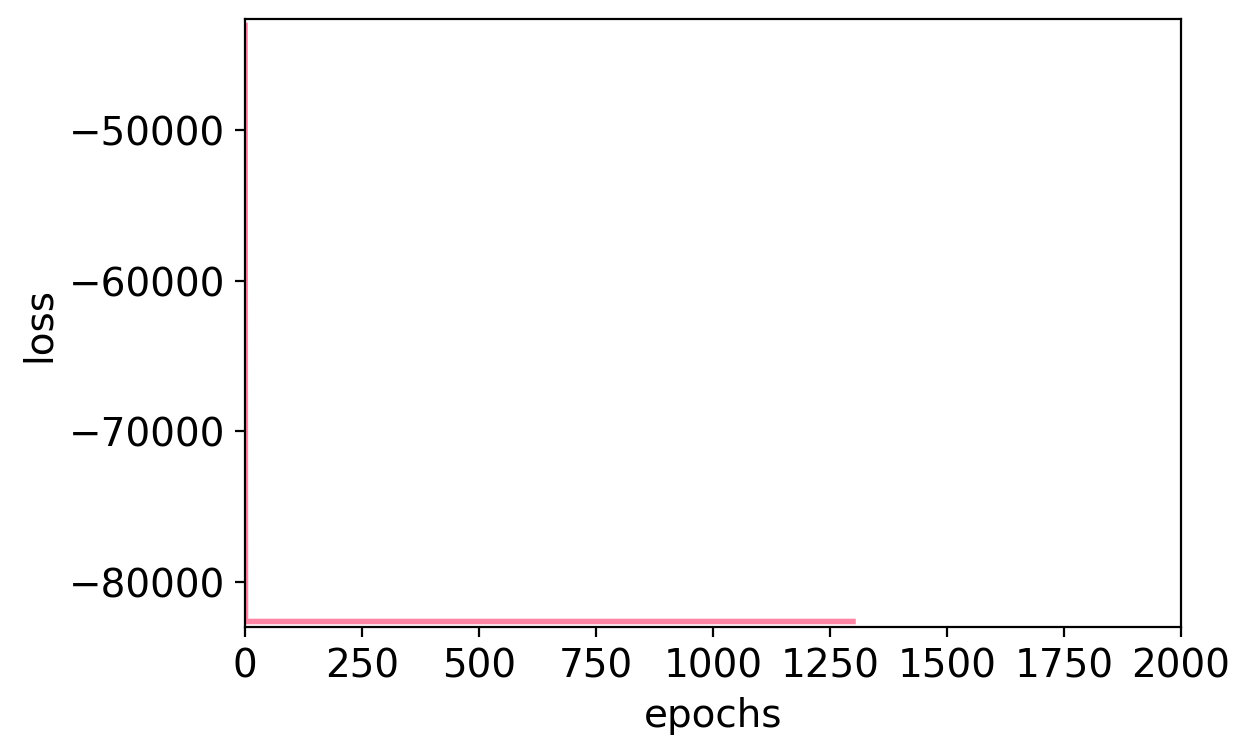

rho=nan
pval=nan
obs_g2g=[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_664853/4002896947.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


spearman_corr=0.007125092973427796
plot losses_scc


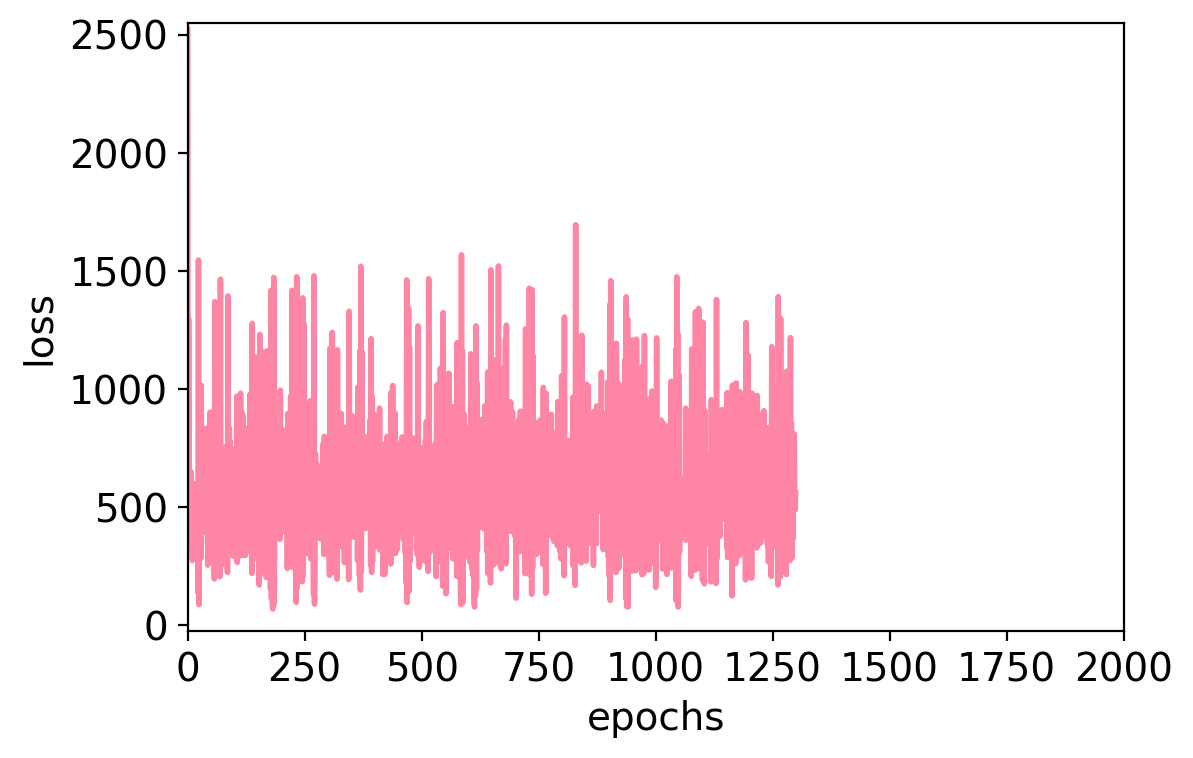

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24300.72it/s]


Computing pair-wise local correlation on 20 features...


100%|████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 485629.35it/s]


output_gex=[[1.55 0.69 0.24 ... 1.   1.   1.  ]
 [0.06 0.74 0.87 ... 1.   1.   1.  ]
 [1.13 0.45 0.28 ... 1.   1.   1.  ]
 ...
 [0.02 1.02 1.21 ... 1.   1.   1.  ]
 [0.27 1.63 0.98 ... 1.   1.   1.  ]
 [0.01 0.86 1.03 ... 1.   1.   1.  ]]
plot losses_ccc


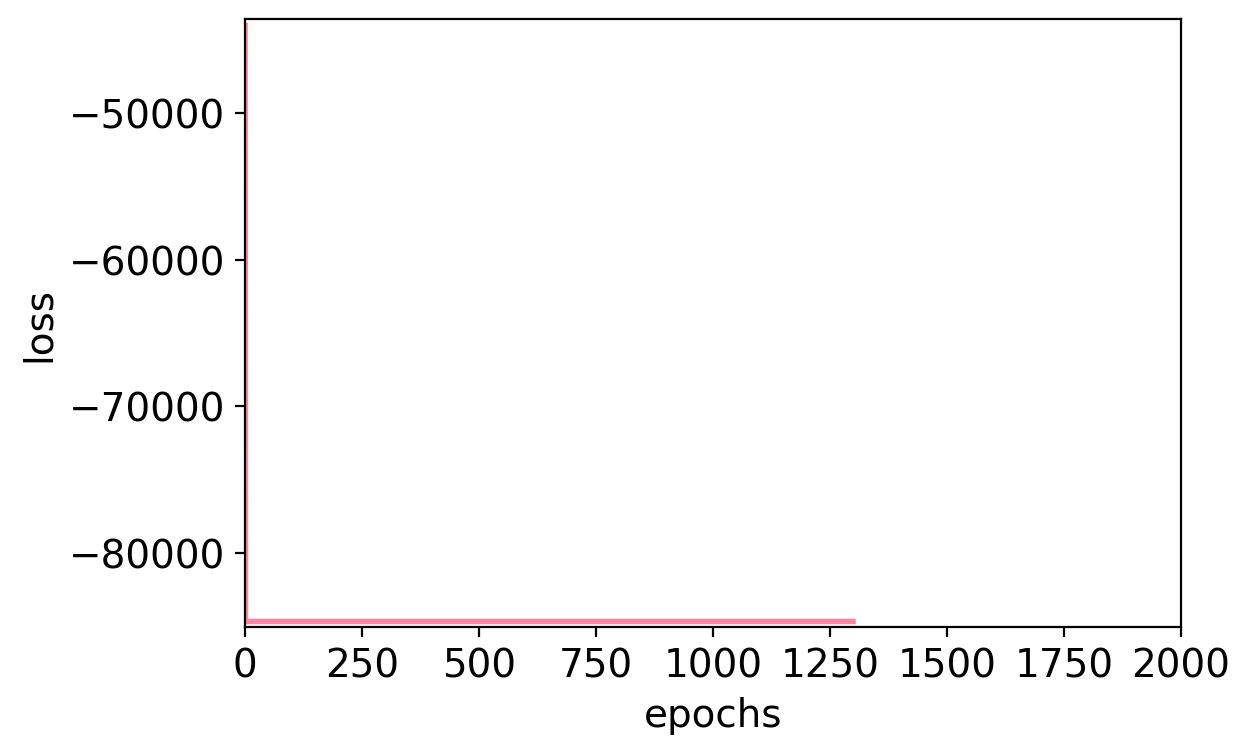

rho=nan
pval=nan
obs_g2g=[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_664853/4002896947.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


spearman_corr=0.00914269999340464
plot losses_scc


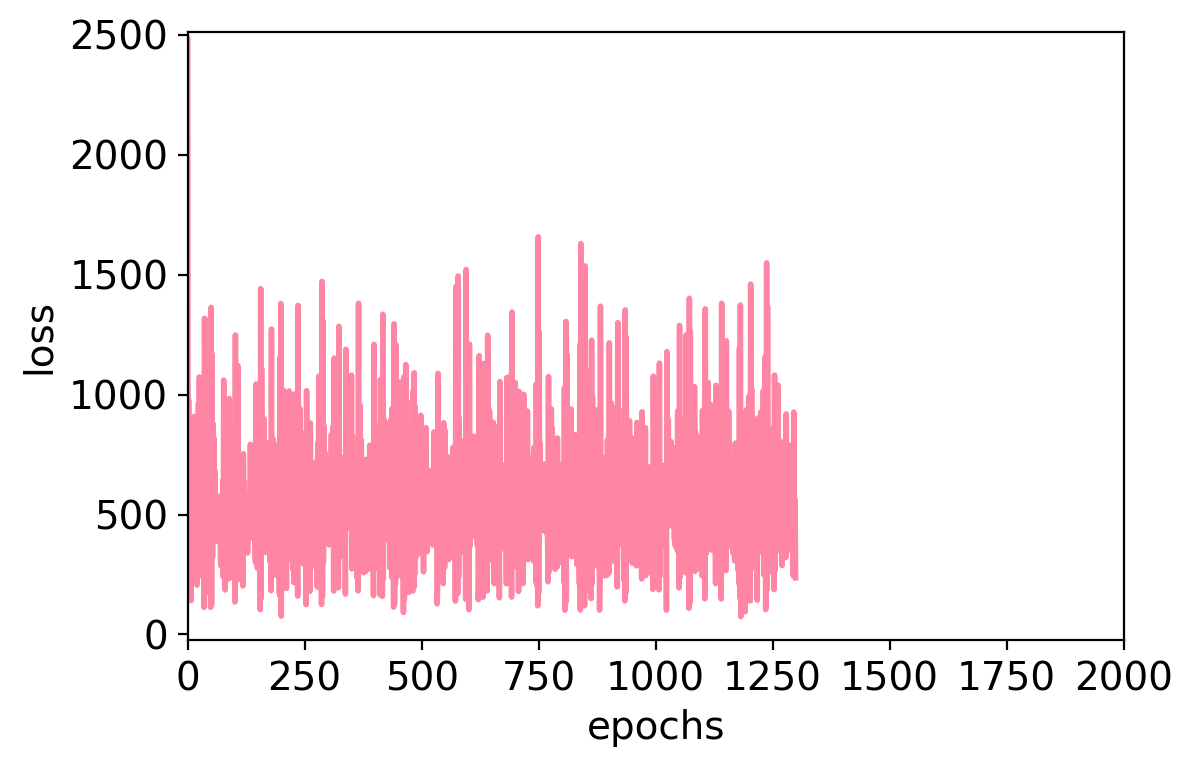

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24614.46it/s]


Computing pair-wise local correlation on 20 features...


100%|████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 524633.15it/s]


output_gex=[[1.76 0.95 0.35 ... 1.   1.   1.  ]
 [0.07 1.36 1.12 ... 1.   1.   1.  ]
 [2.   0.94 1.03 ... 1.   1.   1.  ]
 ...
 [0.91 0.68 1.92 ... 1.   1.   1.  ]
 [0.89 0.56 0.49 ... 1.   1.   1.  ]
 [1.03 1.92 0.68 ... 1.   1.   1.  ]]
plot losses_ccc


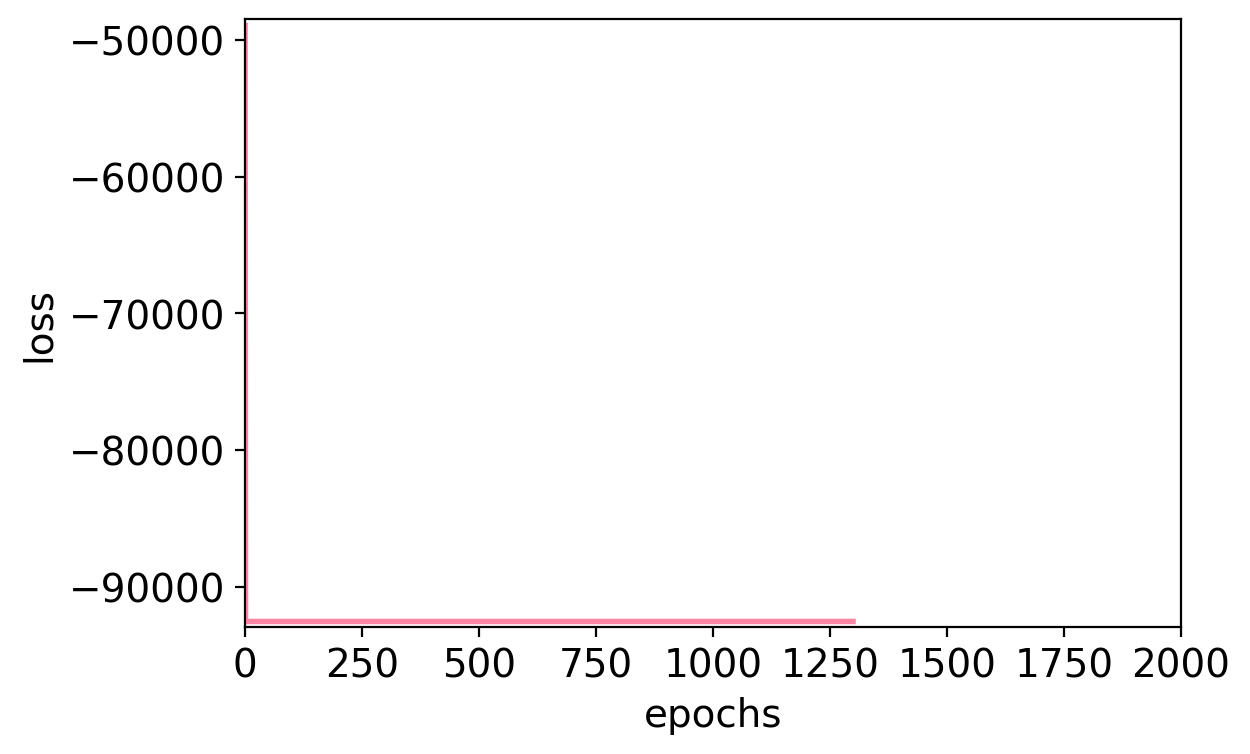

rho=nan
pval=nan
obs_g2g=[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_664853/4002896947.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


spearman_corr=0.01461979927434641
plot losses_scc


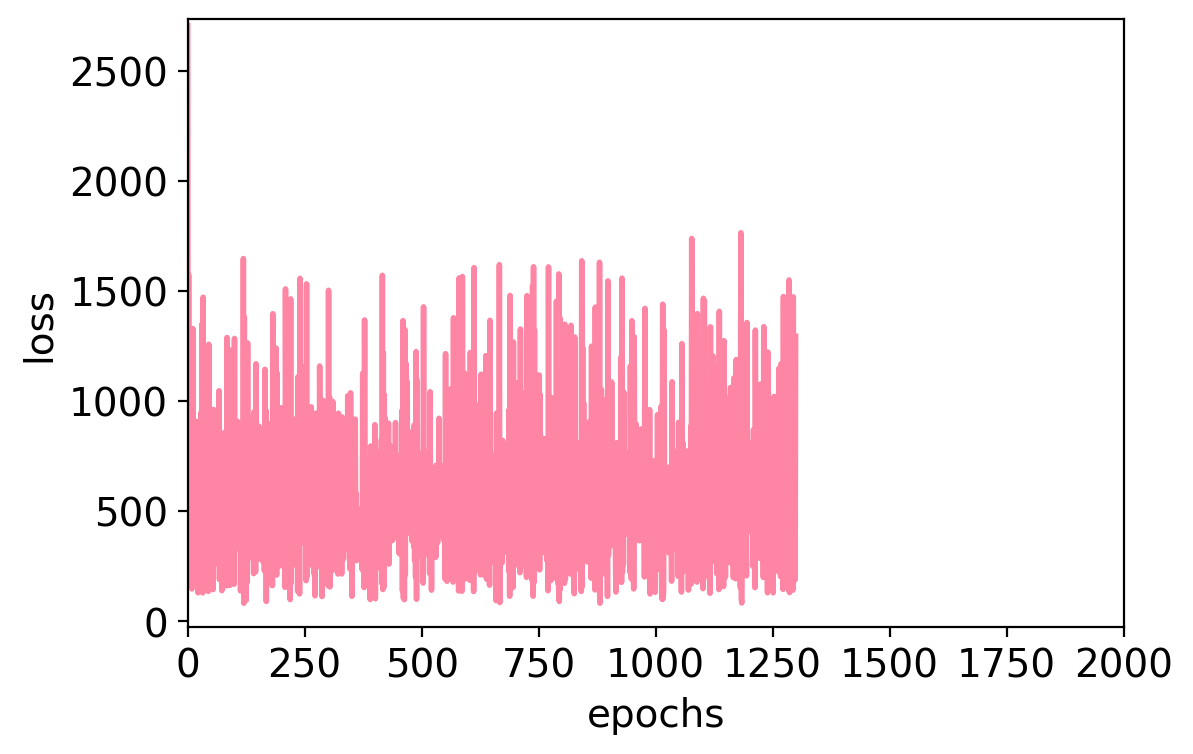

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23919.61it/s]


Computing pair-wise local correlation on 20 features...


100%|████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 532699.04it/s]


output_gex=[[0.05 0.74 1.19 ... 1.   1.   1.  ]
 [1.7  0.31 1.1  ... 1.   1.   1.  ]
 [0.82 0.27 0.73 ... 1.   1.   1.  ]
 ...
 [0.35 0.27 0.78 ... 1.   1.   1.  ]
 [0.28 0.58 0.94 ... 1.   1.   1.  ]
 [0.32 0.56 0.91 ... 1.   1.   1.  ]]
plot losses_ccc


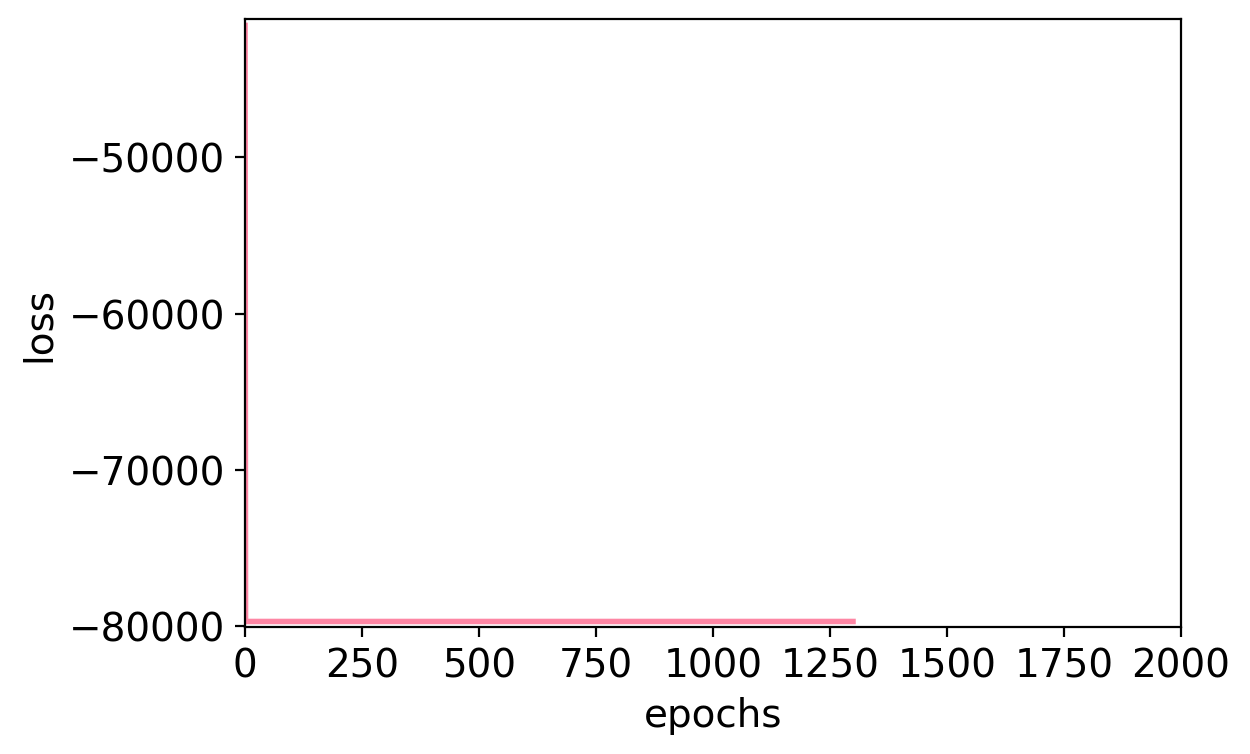

rho=nan
pval=nan
obs_g2g=[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_664853/4002896947.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


spearman_corr=0.03490272261399897
plot losses_scc


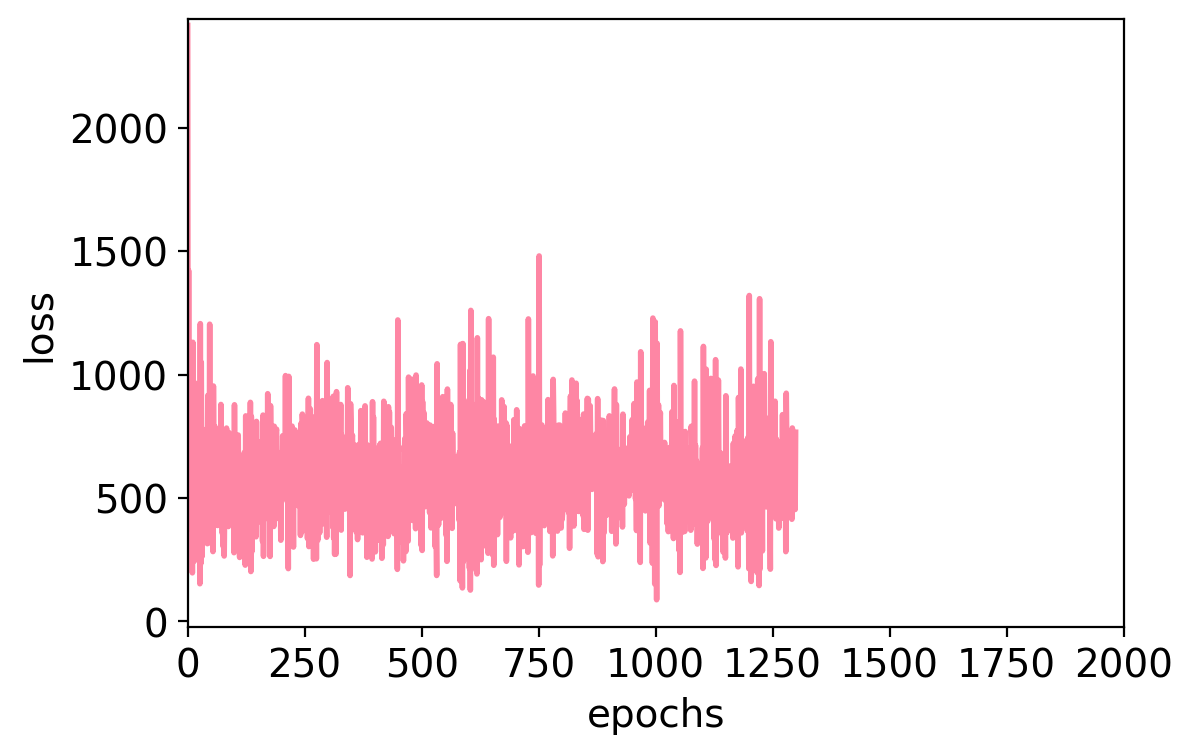

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24015.48it/s]


Computing pair-wise local correlation on 20 features...


100%|████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 530218.07it/s]


output_gex=[[0.03 1.03 1.04 ... 0.95 0.94 0.96]
 [1.26 0.33 0.48 ... 1.   1.   1.  ]
 [0.03 0.84 0.87 ... 1.   1.   1.  ]
 ...
 [1.5  0.15 0.89 ... 1.   1.   1.  ]
 [1.77 0.41 1.15 ... 1.   1.   1.  ]
 [0.49 0.31 0.48 ... 1.   1.   1.  ]]
plot losses_ccc


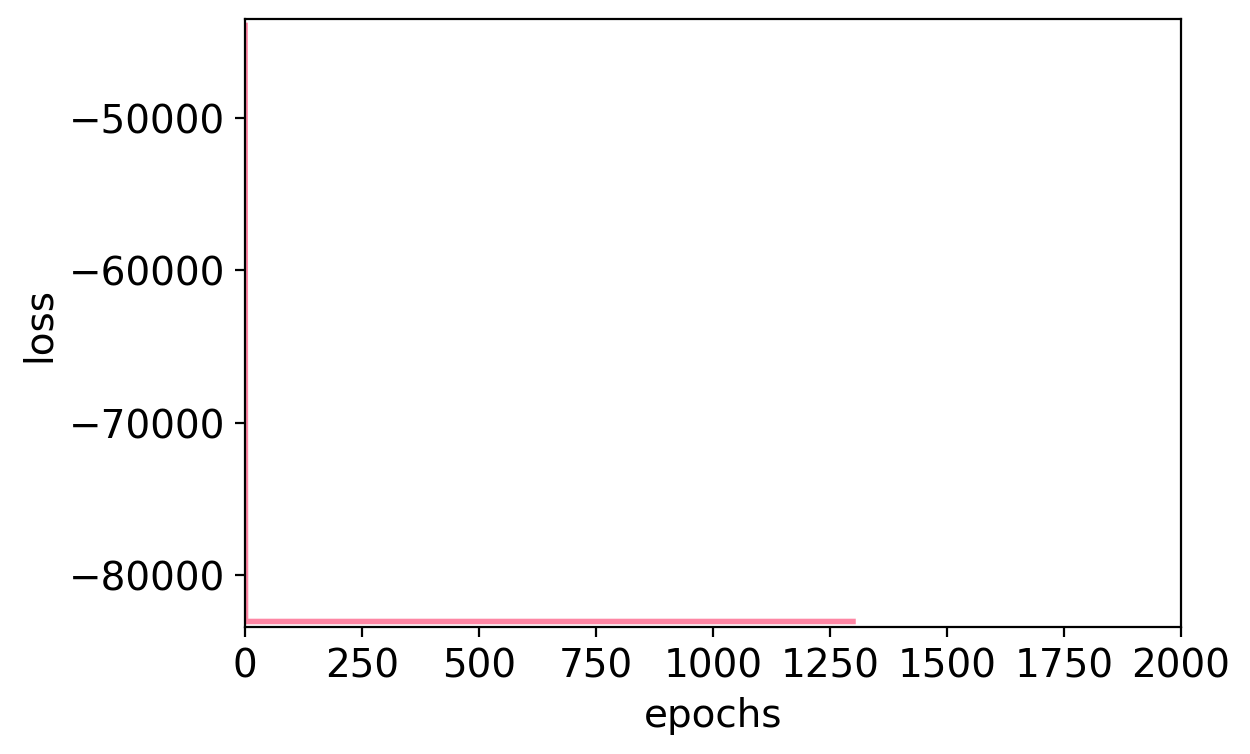

rho=nan
pval=nan
obs_g2g=[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_664853/4002896947.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


spearman_corr=0.04751575683681561
plot losses_scc


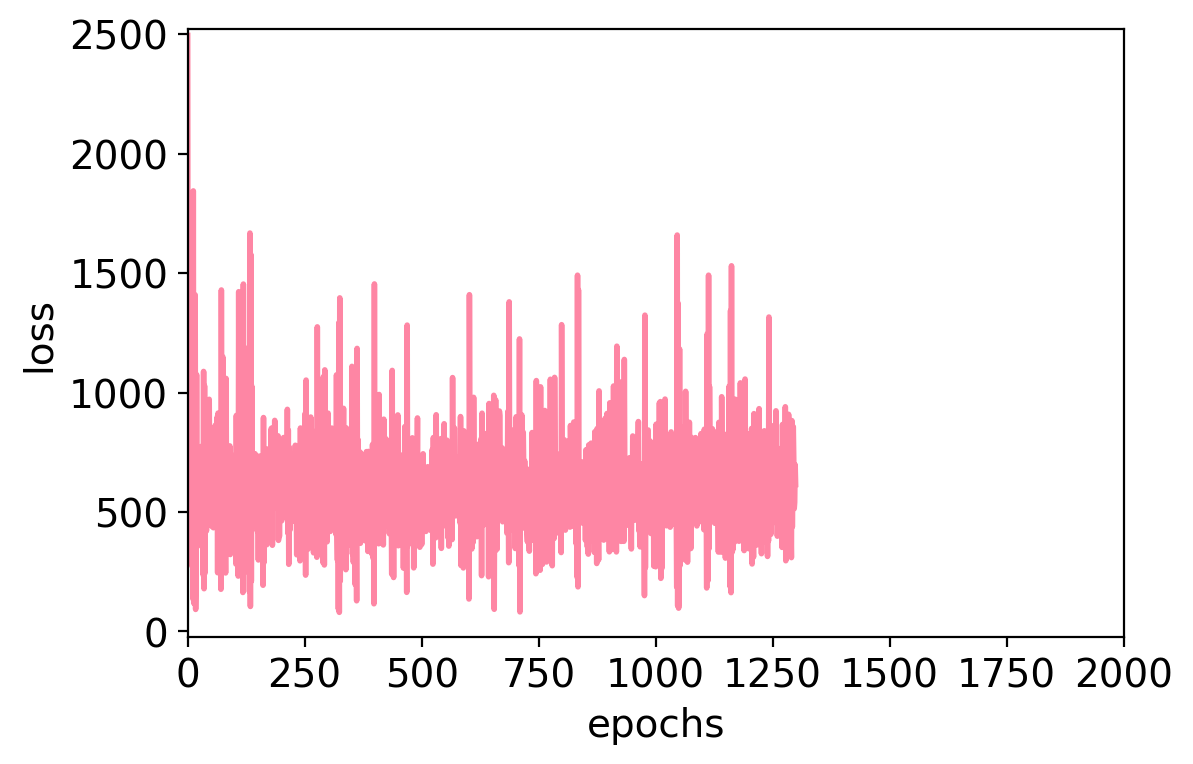

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25297.37it/s]


Computing pair-wise local correlation on 20 features...


100%|████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 549598.46it/s]


output_gex=[[1.91 1.21 1.21 ... 0.98 0.98 0.98]
 [1.03 1.67 1.59 ... 0.98 0.98 0.98]
 [1.79 0.67 0.69 ... 0.95 0.96 0.95]
 ...
 [1.91 0.85 0.82 ... 0.93 0.93 0.92]
 [0.03 1.28 0.94 ... 0.98 0.98 0.98]
 [1.33 0.06 1.13 ... 0.98 0.98 0.98]]
plot losses_ccc


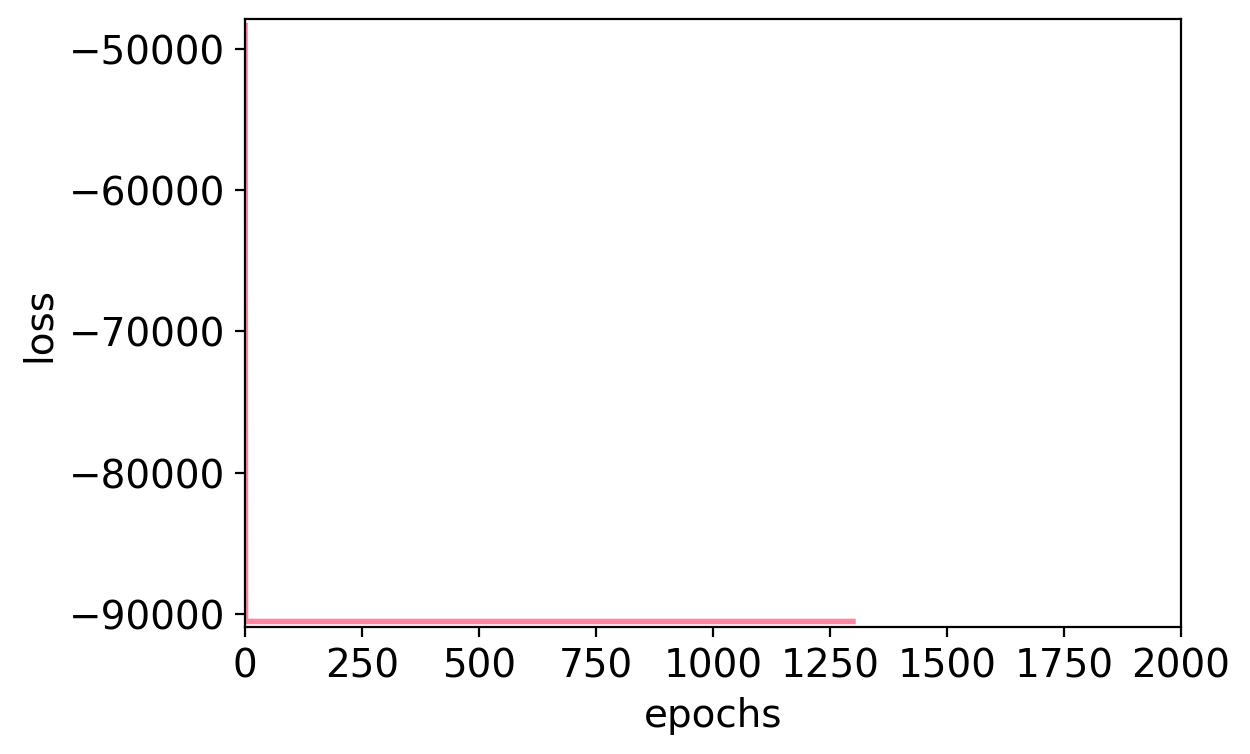

rho=nan
pval=nan
obs_g2g=[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_664853/4002896947.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


spearman_corr=-0.05337243212752015
plot losses_scc


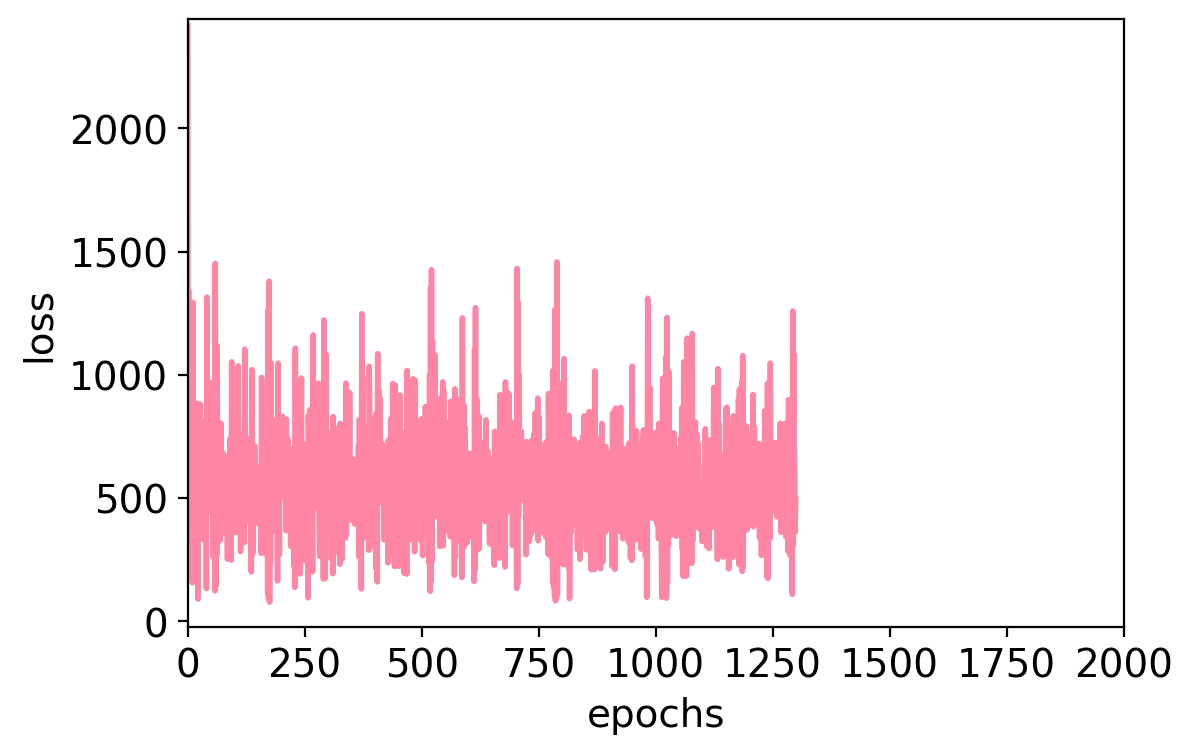

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24385.49it/s]


Computing pair-wise local correlation on 20 features...


100%|████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 538094.37it/s]


output_gex=[[1.17 1.03 0.03 ... 1.   1.   1.  ]
 [1.63 0.33 0.84 ... 1.   1.   1.  ]
 [1.53 0.92 0.7  ... 0.98 0.98 0.98]
 ...
 [1.68 0.29 1.17 ... 1.   1.   1.  ]
 [0.32 1.09 1.63 ... 1.   1.   1.  ]
 [1.83 0.55 0.79 ... 1.   1.   1.  ]]
plot losses_ccc


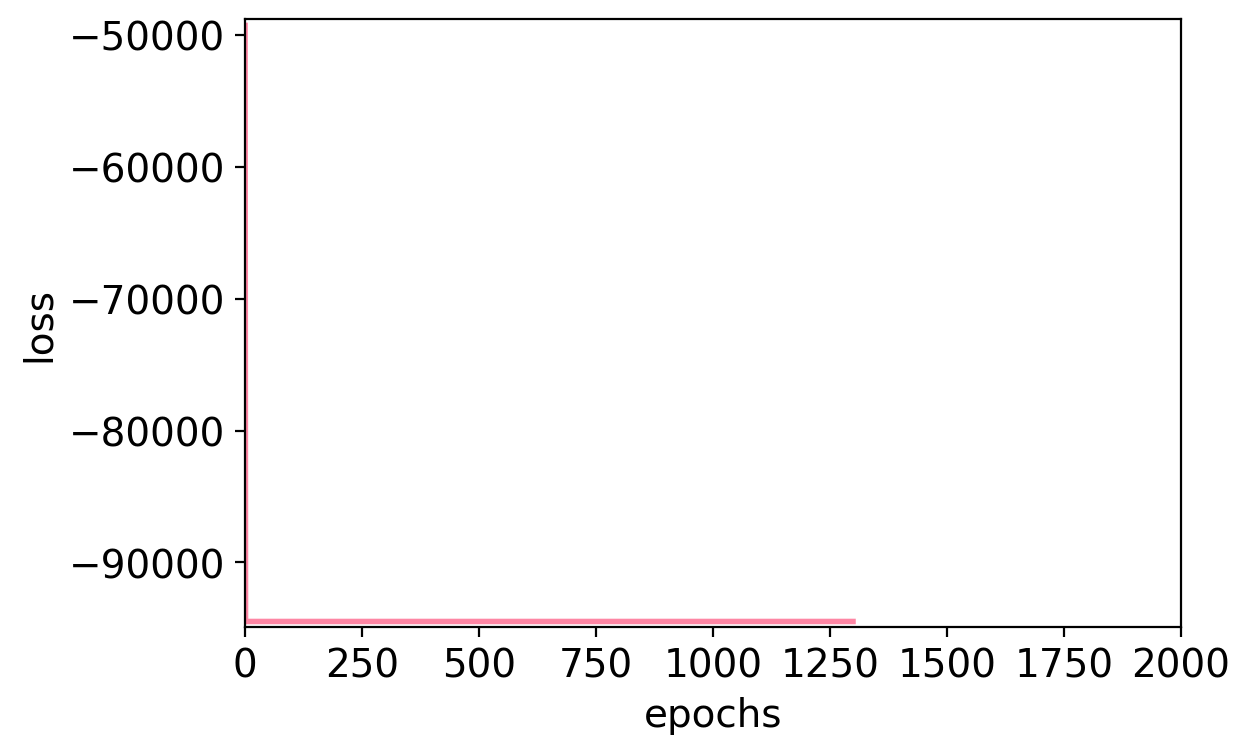

rho=nan
pval=nan
obs_g2g=[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_664853/4002896947.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


spearman_corr=0.004482546120760109
plot losses_scc


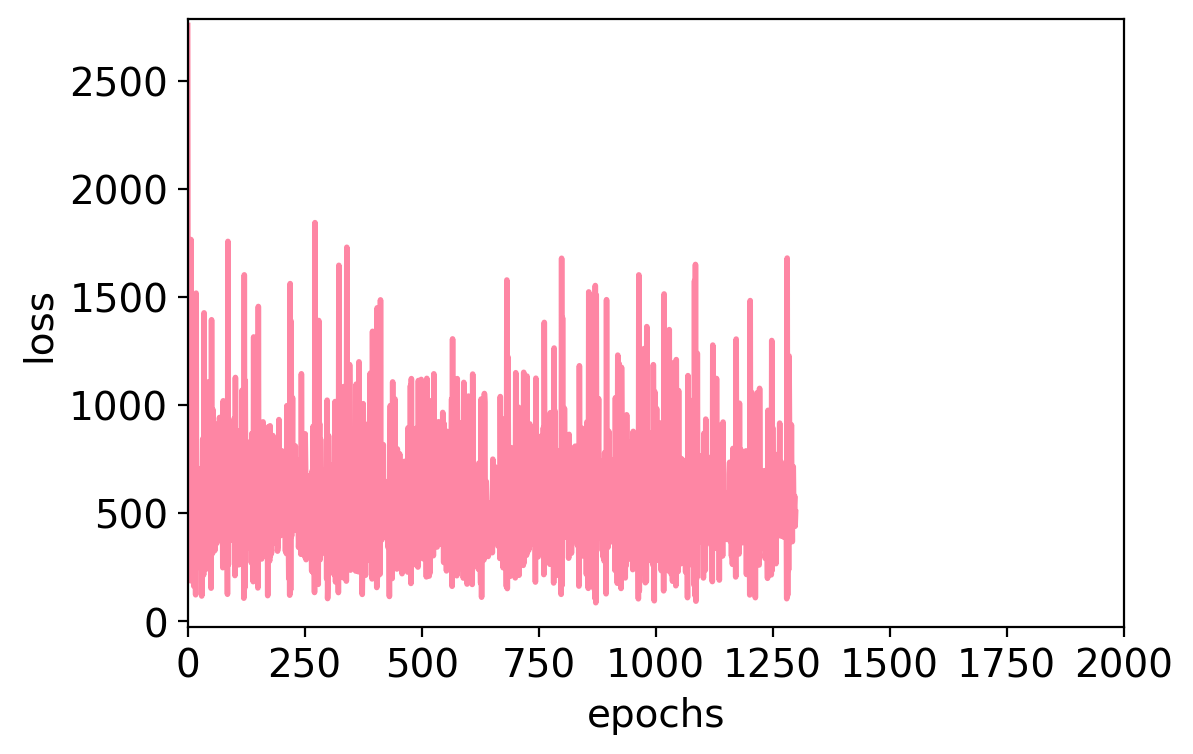

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24789.03it/s]


Computing pair-wise local correlation on 20 features...


100%|████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 488307.45it/s]


output_gex=[[0.36 1.77 0.99 ... 1.   1.   1.  ]
 [0.46 1.05 1.83 ... 1.   1.   1.  ]
 [1.05 0.35 0.98 ... 1.   1.   1.  ]
 ...
 [0.04 1.07 1.19 ... 1.   1.   1.  ]
 [1.98 0.91 0.91 ... 1.   1.   1.  ]
 [0.14 0.58 0.74 ... 1.   1.   1.  ]]
plot losses_ccc


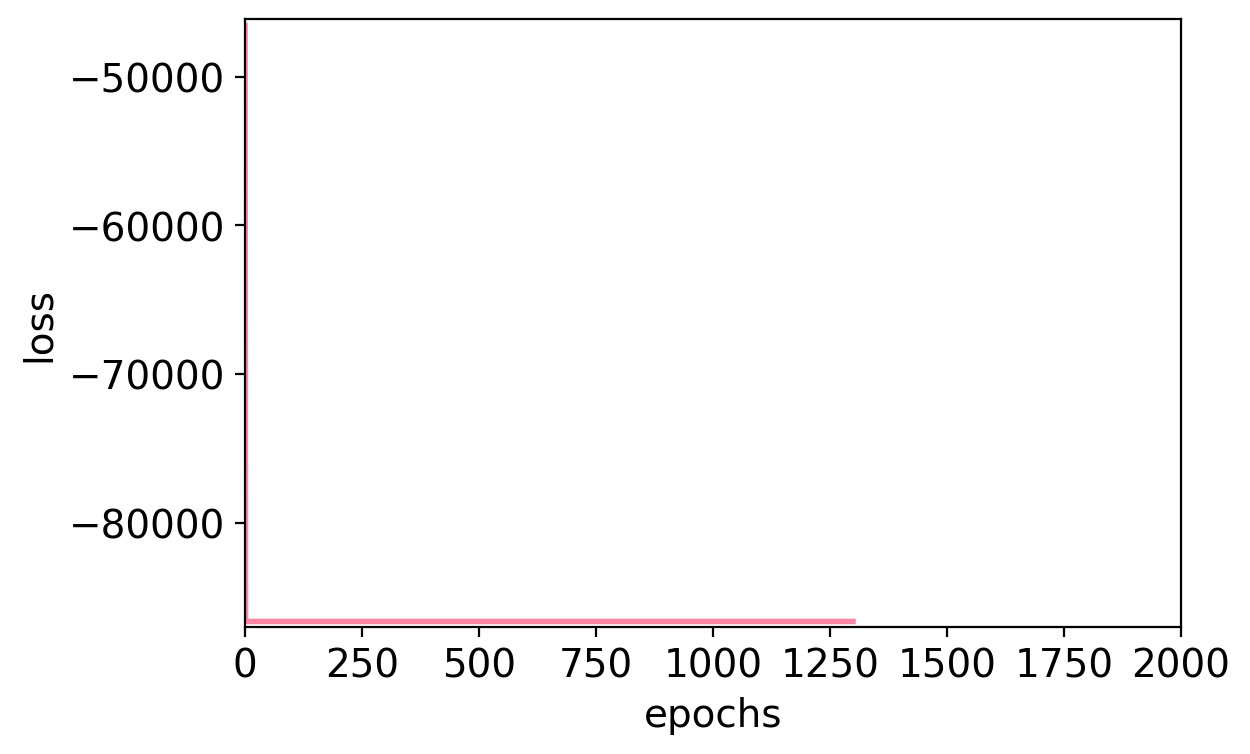

rho=nan
pval=nan
obs_g2g=[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_664853/4002896947.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


spearman_corr=0.10248558271791423
plot losses_scc


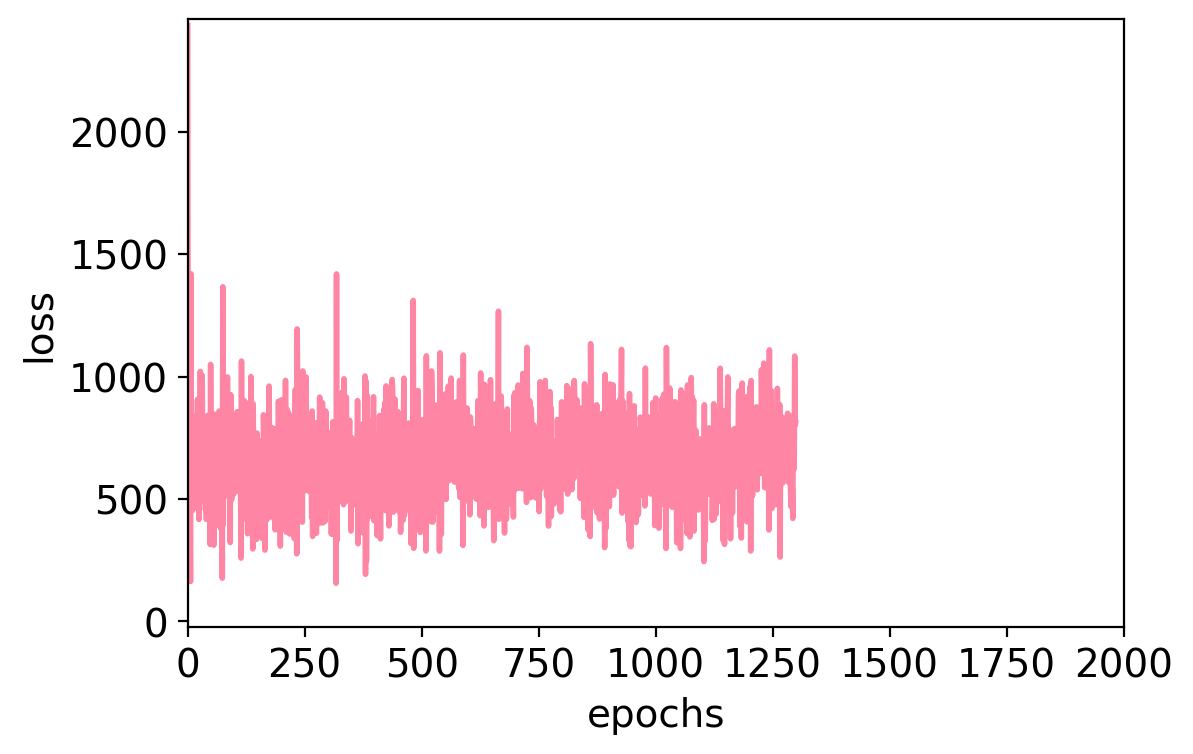

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24694.17it/s]


Computing pair-wise local correlation on 20 features...


100%|████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 502787.23it/s]


output_gex=[[1.65 0.86 0.47 ... 0.97 0.98 0.98]
 [1.91 1.28 1.15 ... 0.98 0.98 0.98]
 [1.85 1.27 1.39 ... 0.98 0.98 0.98]
 ...
 [1.91 1.31 1.01 ... 0.98 0.98 0.98]
 [1.33 1.71 1.07 ... 0.98 0.98 0.98]
 [1.67 1.35 1.51 ... 0.98 0.98 0.98]]
plot losses_ccc


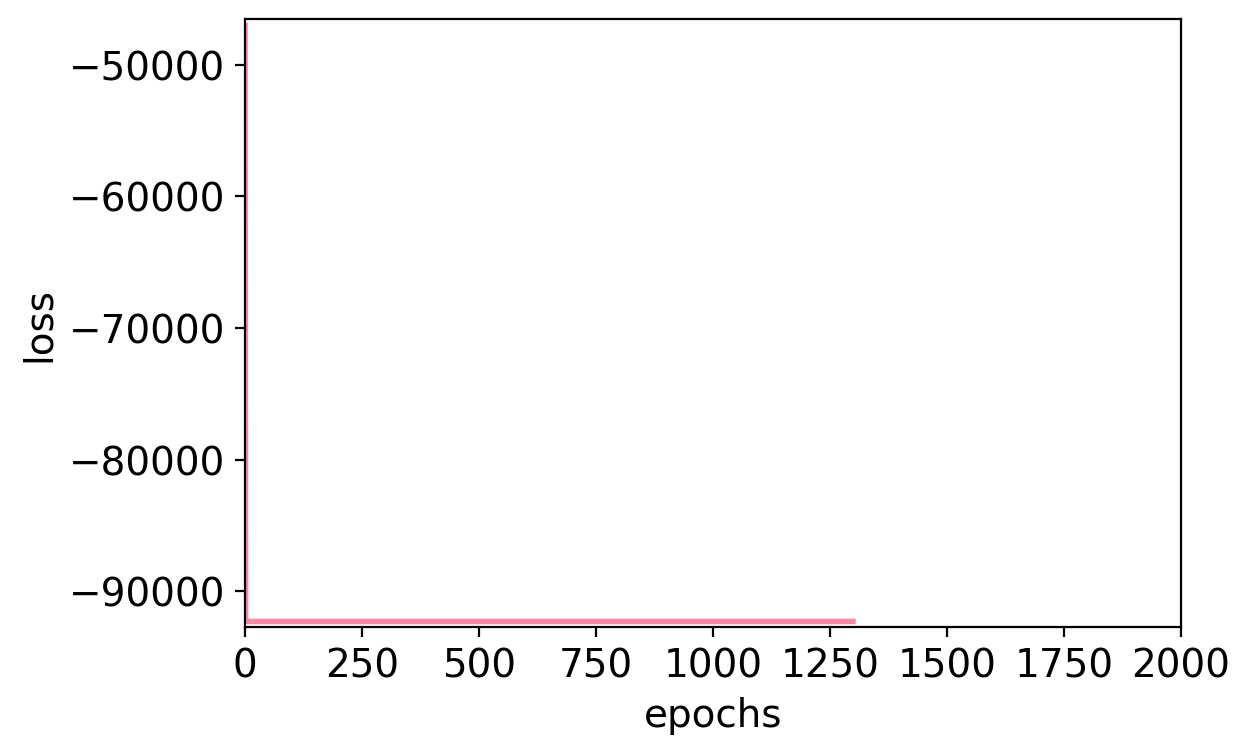

rho=nan
pval=nan
obs_g2g=[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_664853/4002896947.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


spearman_corr=0.010711980849146612
plot losses_scc


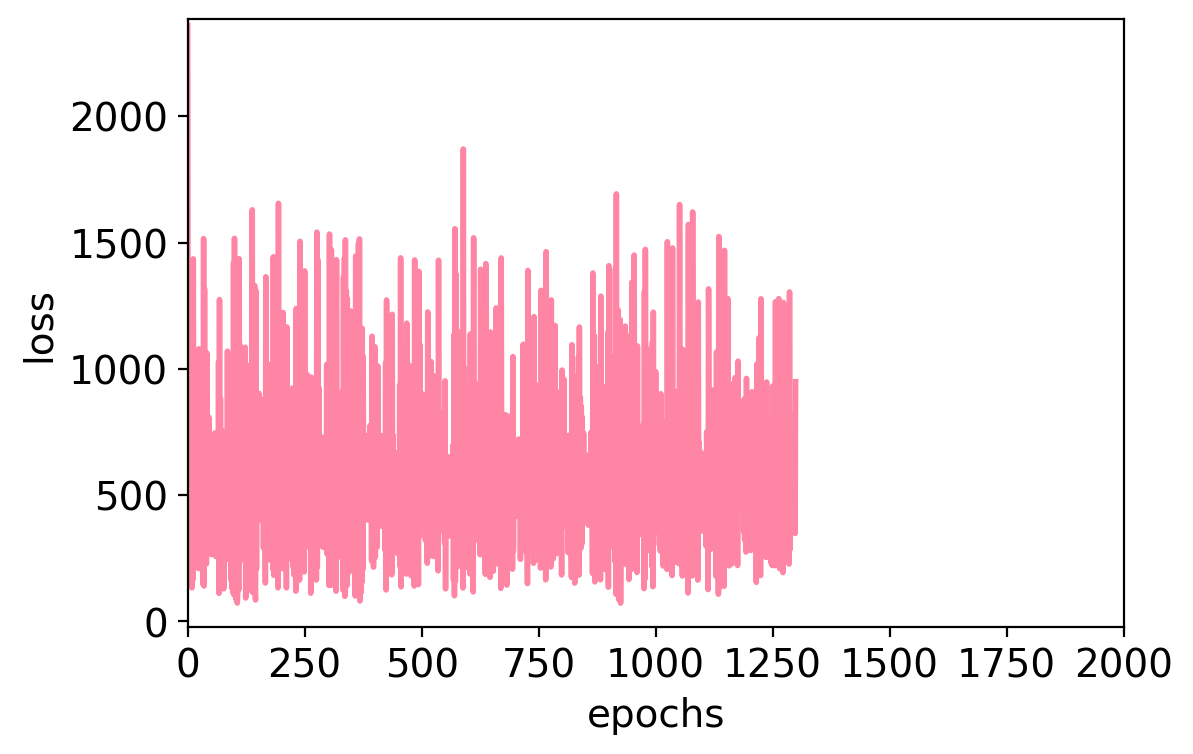

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25312.64it/s]


Computing pair-wise local correlation on 20 features...


100%|████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 538094.37it/s]


output_gex=[[0.   0.91 0.96 ... 1.   1.   1.  ]
 [0.56 1.1  0.24 ... 1.   1.   1.  ]
 [0.11 0.64 0.73 ... 1.   1.   1.  ]
 ...
 [0.38 0.22 0.92 ... 1.   1.   1.  ]
 [1.78 0.8  0.48 ... 1.   1.   1.  ]
 [1.59 0.73 0.62 ... 0.92 0.92 0.91]]
plot losses_ccc


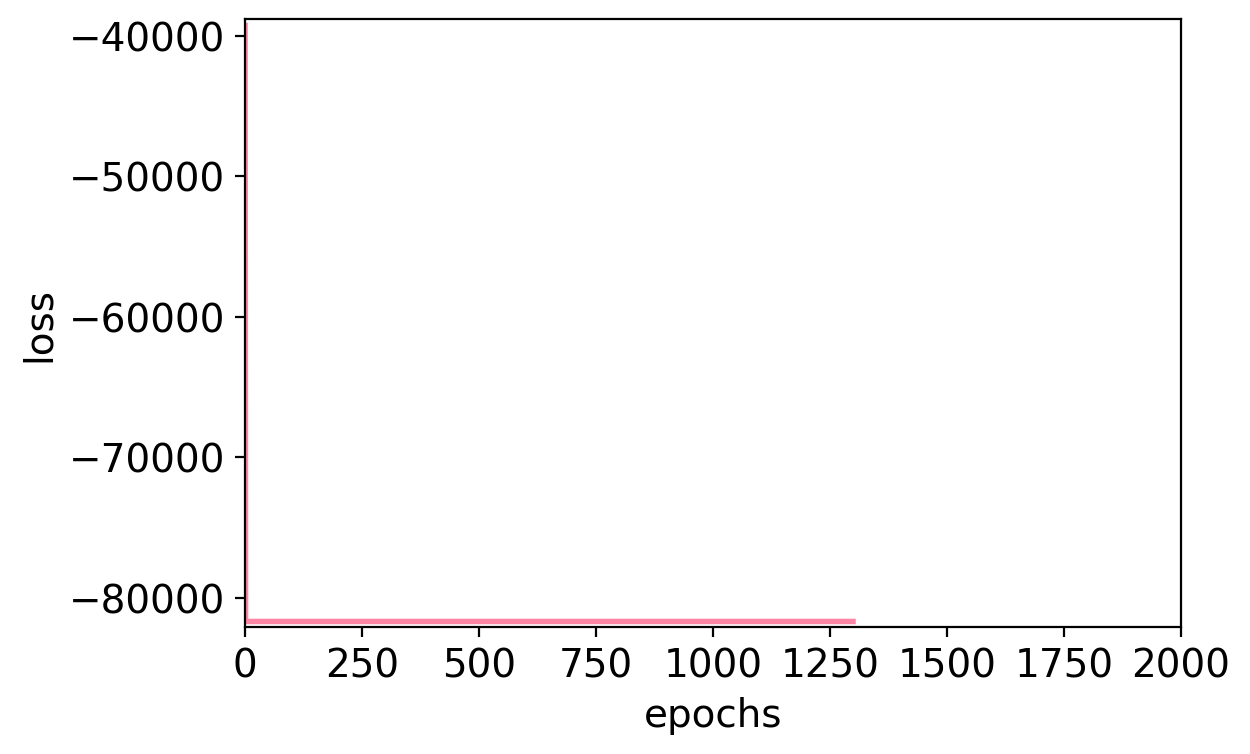

rho=nan
pval=nan
obs_g2g=[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_664853/4002896947.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


In [73]:
import multiprocessing as mp
from tqdm import tqdm
import time
import hotspot
rhos_list = []
# define the parameters
n_x, n_y, n_genes = 10, 10, 20
learning_rate = 1e-1
zmft_scalar = 0.01
epochs = 1300
# define the parameters
n_sims = 10
params_list = [[n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs] for seed in list(range(0,100*n_sims, 100) ) ]
# run the simulations
results_list = []
t0 = time.time()
for i, params in enumerate(params_list):
    print(f"simulation {i}; time passed: {time.time() - t0}")
    results = run_sim_vs_hotspot(params)
    results_list.append(results)

print(rhos_list)

In [ ]:
# def run_sim(params):
#     # unpack the parameters
#     n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs = params
#     # set the seed
#     np.random.seed(seed)
#     # define the input g2g
#     #input_g2g = gen_g2g(n_genes)
#     input_g2g = gen_g2g_uni(n_genes)
#     # run the simulation
#     losses_scc, input_gex, output_gex, exp_g2g = run_scc(input_g2g, params)
    
#     print("plot losses_scc")
#     fig, ax = plt.subplots(figsize=[6, 4])
#     ax.grid(False)
#     ax.plot(losses_scc, lw=2, color='#fe86a4')
#     ax.set_xlim(0, 2000)
#     vmin, vmax = min(min(losses_scc), 0), max(losses_scc)
#     vstep = (vmax - vmin) * 0.01
#     ax.set_ylim(vmin-vstep, vmax+vstep)
#     ax.set(xlabel='epochs', ylabel='loss')
#     plt.show()

#     # define results from ccc
#     losses_ccc, obs_g2g_ccc, obs_g2g_intra = run_ccc_from_scc(output_gex, params)
#     obs_g2g = obs_g2g_ccc.copy()
#     # instantiate a series of the results
#     results = pd.Series()
#     results.loc['loss_scc'] = losses_scc[-1]
#     results.loc['loss_ccc'] = losses_ccc[-1]

#     print("plot losses_ccc")
#     fig, ax = plt.subplots(figsize=[6, 4])
#     ax.grid(False)
#     ax.plot(losses_ccc, lw=2, color='#fe86a4')
#     ax.set_xlim(0, 2000)
#     vmin, vmax = min(min(losses_ccc), 0), max(losses_ccc)
#     vstep = (vmax - vmin) * 0.01
#     ax.set_ylim(vmin-vstep, vmax+vstep)
#     ax.set(xlabel='epochs', ylabel='loss')
#     plt.show()
    
#     # derive the correlation (from ccc)
#     rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
#     rhos_list.append(rho)
#     print(f"rho={rho}")
#     print(f"pval={pval}")
#     print(f"obs_g2g={np.round(obs_g2g, 2)}")
#     print(f"exp_g2g={np.round(exp_g2g,2)}")
#     results.loc['spearman_ccc_out_vs_scc_in.r'] = rho
#     results.loc['spearman_ccc_out_vs_scc_in.p'] = pval
    
#     # derive the correlation (correlations of the gex)
#     gex_corr = pd.DataFrame(output_gex).corr(method='spearman').values
#     rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
#     results.loc['spearman_scc_gex_corr_vs_scc_in.r'] = rho
#     results.loc['spearman_scc_gex_corr_vs_scc_in.p'] = pval
    
#     # derive the correlation (correlations of the gex)
#     gex_corr = pd.DataFrame(input_gex).corr(method='spearman').values
#     rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
#     results.loc['spearman_in_gex_corr_vs_scc_in.r'] = rho
#     results.loc['spearman_in_gex_corr_vs_scc_in.p'] = pval
    
#     # name it based on the seed
#     results.name = f'seed_{seed}'
#     results_ccc = results.copy()

#     # define results from ccc
#     obs_g2g = obs_g2g_intra.copy()
#     # instantiate a series of the results
#     results = pd.Series()
#     results.loc['loss_scc'] = losses_scc[-1]
#     results.loc['loss_ccc'] = losses_ccc[-1]
    
#     # derive the correlation (from ccc)
#     rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
#     print(f"rho={rho}")
#     print(f"pval={pval}")
    
#     results.loc['spearman_ccc_out_vs_scc_in.r'] = rho
#     results.loc['spearman_ccc_out_vs_scc_in.p'] = pval
    
#     # derive the correlation (correlations of the gex)
#     gex_corr = pd.DataFrame(output_gex).corr(method='spearman').values
#     rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
#     results.loc['spearman_scc_gex_corr_vs_scc_in.r'] = rho
#     results.loc['spearman_scc_gex_corr_vs_scc_in.p'] = pval
    
#     # derive the correlation (correlations of the gex)
#     gex_corr = pd.DataFrame(input_gex).corr(method='spearman').values
#     rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
#     results.loc['spearman_in_gex_corr_vs_scc_in.r'] = rho
#     results.loc['spearman_in_gex_corr_vs_scc_in.p'] = pval
    
#     # name it based on the seed
#     results.name = f'seed_{seed}'
#     results_intra = results.copy()
    
#     return results_ccc, results_intra

In [ ]:
# import multiprocessing as mp
# from tqdm import tqdm
# import time
# rhos_list = []
# # define the parameters
# n_x, n_y, n_genes = 10, 10, 8
# learning_rate = 1e-1
# zmft_scalar = 0.01
# epochs = 1000
# # define the parameters
# n_sims = 100
# params_list = [[n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs] for seed in list(range(0,100*n_sims, 100) ) ]
# # run the simulations
# results_list = []
# t0 = time.time()
# for i, params in enumerate(params_list):
#     print(f"simulation {i}; time passed: {time.time() - t0}")
#     results = run_sim(params)
#     results_list.append(results)

# print(rhos_list)

In [ ]:
np.nanmean(rhos_list )


In [ ]:
# import multiprocessing as mp
# from tqdm import tqdm
# import time
# # define the parameters
# n_x, n_y, n_genes = 10, 10, 50
# learning_rate = 1e-1
# zmft_scalar = 1e-1
# epochs = 2000
# # define the parameters
# n_sims = 5
# params_list = [[n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs] for seed in range(n_sims)]
# # run the simulations
# results_list = []
# t0 = time.time()
# for i, params in enumerate(params_list):
#     print(f"simulation {i}; time passed: {time.time() - t0}")
#     results = run_sim(params)
#     results_list.append(results)

In [ ]:
# import multiprocessing as mp
# from tqdm import tqdm
# # define the parameters
# n_x, n_y, n_genes = 10, 10, 4
# learning_rate = 1e-1
# zmft_scalar = 1e-1
# epochs = 2000
# # define the parameters
# n_sims = 100
# params_list = [[n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs] for seed in range(n_sims)]
# # run the simulations
# results_list = []
# with mp.Pool(30) as pool:
#     for results in tqdm(pool.imap(run_sim, params_list), total=n_sims):
#         results_list.append(results)

In [48]:
results_list[1][0]

loss_scc                             9.296089e+01
loss_ccc                             1.689498e+02
spearman_ccc_out_vs_scc_in.r         5.838141e-01
spearman_ccc_out_vs_scc_in.p         4.113157e-07
spearman_scc_gex_corr_vs_scc_in.r    2.718830e-01
spearman_scc_gex_corr_vs_scc_in.p    2.975661e-02
spearman_in_gex_corr_vs_scc_in.r     4.511749e-01
spearman_in_gex_corr_vs_scc_in.p     1.827971e-04
spearman_hotspot.r                  -8.357136e-02
spearman_hotspot.p                   5.114743e-01
Name: seed_100, dtype: float32

In [63]:
# define the order of the metrics
order = ['loss_scc','loss_ccc',
         'spearman_ccc_out_vs_scc_in.r','spearman_ccc_out_vs_scc_in.p',
         'spearman_scc_gex_corr_vs_scc_in.r','spearman_scc_gex_corr_vs_scc_in.p',
         # 'spearman_in_gex_corr_vs_scc_in.r','spearman_in_gex_corr_vs_scc_in.p', 
         'spearman_hotspot.r', 'spearman_hotspot.p']
results_ccc = pd.concat([el[0] for el in results_list], axis=1).loc[order]
# results_intra = pd.concat([el[1] for el in results_list], axis=1).loc[order]

In [64]:
results_ccc

,seed_0,seed_100,seed_200,seed_300,seed_400,seed_500,seed_600,seed_700,seed_800,seed_900
loss_scc,7.232587e+02,5.075097e+02,210.743729,948.420227,4.356029e+02,5.807231e+02,6.694307e+02,6.332495e+02,7.990464e+02,1034.409790
loss_ccc,1.800774e+02,1.096384e+02,145.188370,171.276413,1.711977e+02,1.097094e+02,1.739660e+02,1.085658e+02,1.828110e+02,98.203728
spearman_ccc_out_vs_scc_in.r,3.730855e-01,3.387802e-01,0.070613,0.233159,2.566952e-01,3.775365e-01,2.992692e-01,3.775393e-01,3.775384e-01,0.142757
spearman_ccc_out_vs_scc_in.p,1.174123e-14,3.371105e-12,0.158655,0.000002,1.936696e-07,5.353605e-15,1.014071e-09,5.350910e-15,5.351853e-15,0.004225
spearman_scc_gex_corr_vs_scc_in.r,1.011701e-01,1.033788e-01,0.119906,0.178011,1.099183e-01,1.347470e-01,7.158157e-02,1.152854e-01,1.025843e-01,0.105689
spearman_scc_gex_corr_vs_scc_in.p,4.314945e-02,3.876749e-02,0.016428,0.000347,2.793831e-02,6.958479e-03,1.530086e-01,2.110025e-02,4.029831e-02,0.034593
spearman_hotspot.r,7.232863e-03,1.264705e-01,0.068833,0.066758,-1.518070e-01,4.324585e-02,4.256157e-02,1.104739e-01,-6.396591e-02,0.006227
spearman_hotspot.p,8.853375e-01,1.135215e-02,0.169447,0.182706,2.332213e-03,3.883499e-01,3.959079e-01,2.715170e-02,2.017357e-01,0.901195


In [65]:
# melt the dataframe into a plottable function (complete this for CCC as before)
data = results_ccc.reset_index().melt(id_vars='index')
data['dataset'] = data['index'].apply(lambda x: '_'.join(x.split('_')[1:]).split('_vs_')[0]).str.replace('_','-')
data['metric'] = data['index'].apply(lambda x: x.split('_')[0]+'.'+x.split('.')[-1])
data['nlog10p1en4_value'] = -np.log10(data['value'].astype(float)+1e-4)
data

/nfs/users/nfs_s/sm58/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,variable,value,dataset,metric,nlog10p1en4_value
0,loss_scc,seed_0,7.232587e+02,scc,loss.loss_scc,-2.859294
1,loss_ccc,seed_0,1.800774e+02,ccc,loss.loss_ccc,-2.255459
2,spearman_ccc_out_vs_scc_in.r,seed_0,3.730855e-01,ccc-out,spearman.r,0.428075
3,spearman_ccc_out_vs_scc_in.p,seed_0,1.174123e-14,ccc-out,spearman.p,4.000000
4,spearman_scc_gex_corr_vs_scc_in.r,seed_0,1.011701e-01,scc-gex-corr,spearman.r,0.994519
...,...,...,...,...,...,...
75,spearman_ccc_out_vs_scc_in.p,seed_900,4.224774e-03,ccc-out,spearman.p,2.364037
76,spearman_scc_gex_corr_vs_scc_in.r,seed_900,1.056890e-01,scc-gex-corr,spearman.r,0.975560
77,spearman_scc_gex_corr_vs_scc_in.p,seed_900,3.459343e-02,scc-gex-corr,spearman.p,1.459753
78,spearman_hotspot.r,seed_900,6.227015e-03,hotspot.r,spearman.r,2.198801


In [66]:
# define the things we wish to plot
plotters = [
            ['spearman.r', 'value', ['in-gex-corr','ccc-out']],
            ['spearman.p', 'nlog10p1en4_value', ['in-gex-corr','ccc-out']],
            ['spearman.r', 'value', ['in-gex-corr','scc-gex-corr']],
            ['spearman.p', 'nlog10p1en4_value', ['in-gex-corr','scc-gex-corr']],
            ['spearman.r', 'value', ['hotspot.r','ccc-out']],
            ['spearman.p', 'nlog10p1en4_value', ['hotspot.p','ccc-out']],
           ]




/tmp/ipykernel_664853/2539865711.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=0,
/tmp/ipykernel_664853/2539865711.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=2,
/software/cellgen/team205/sm58/envs/celcomen_env_20241203/lib/python3.10/site-packages/scipy/_lib/_util.py:798: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return fun(*args, **kwargs)
/tmp/ipykernel_664853/2539865711.py:24: SmallSampleWarning: One or more sample argum

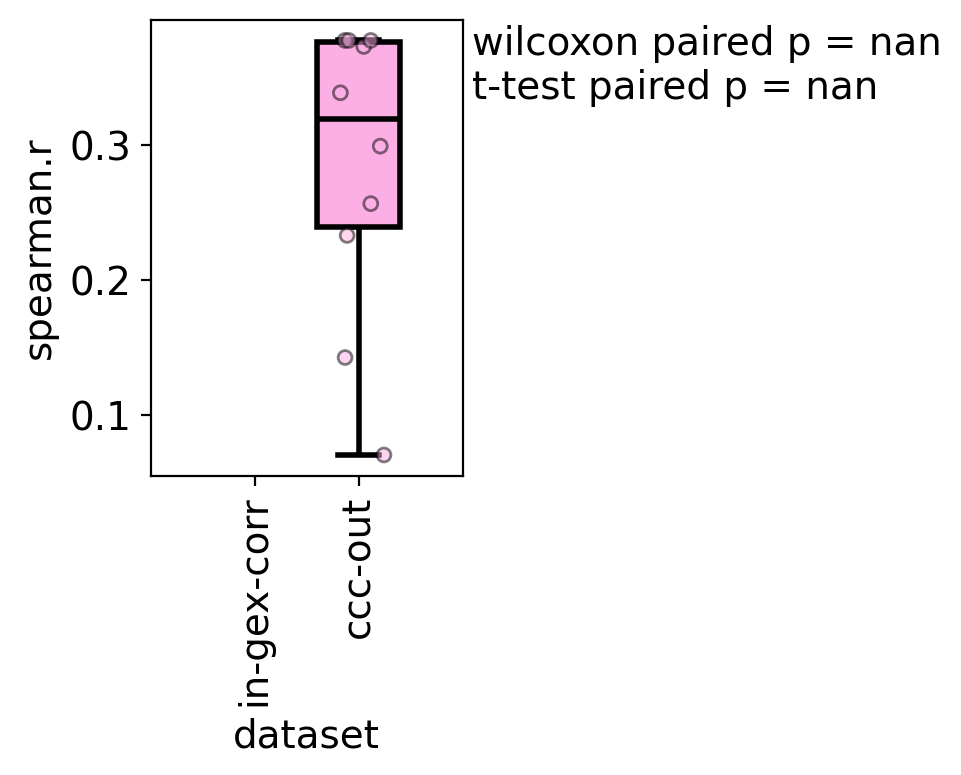

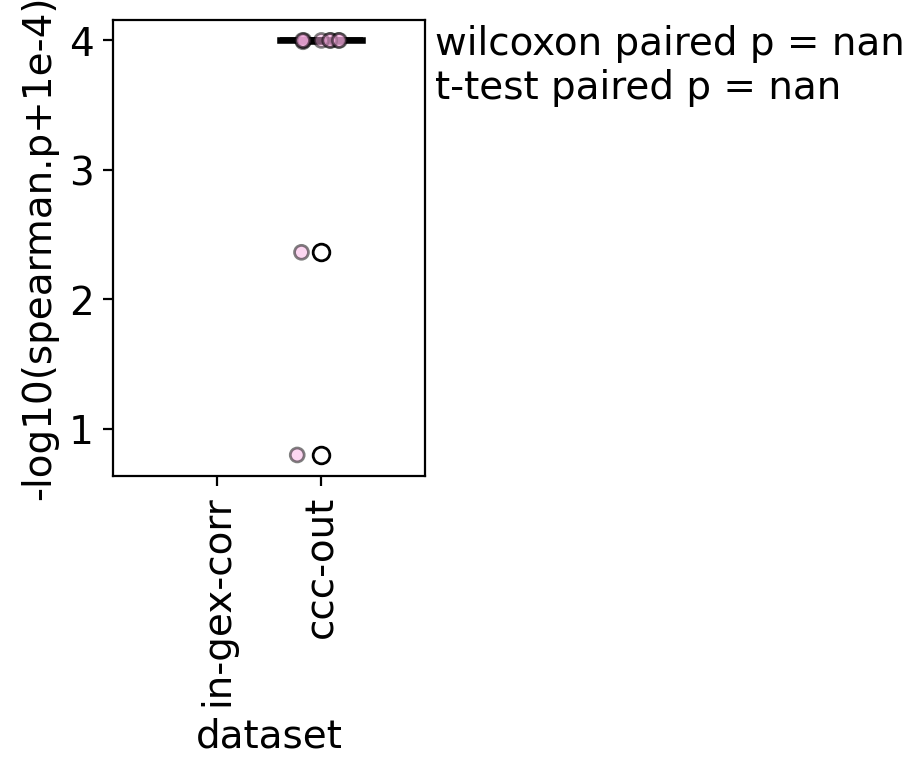

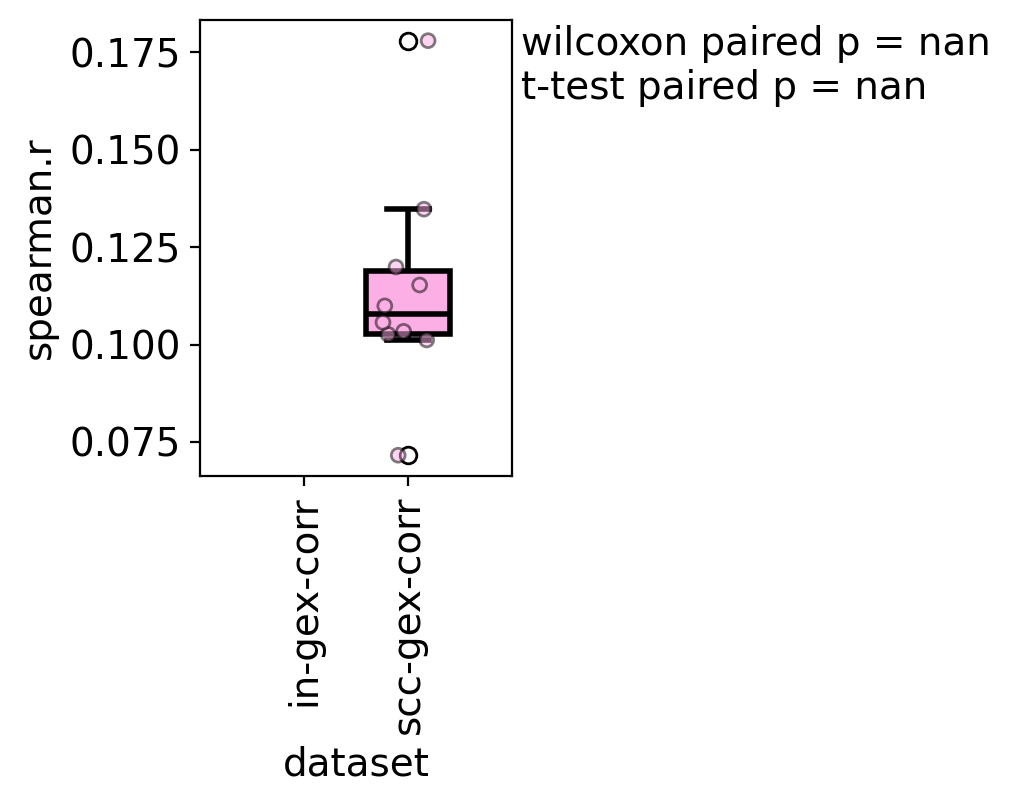

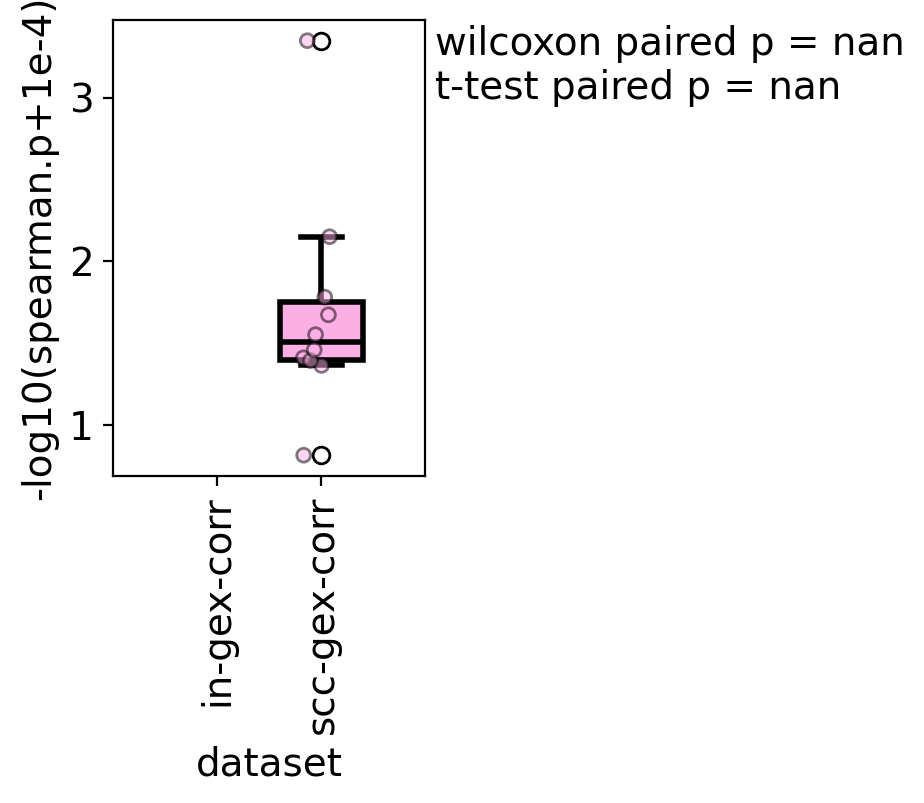

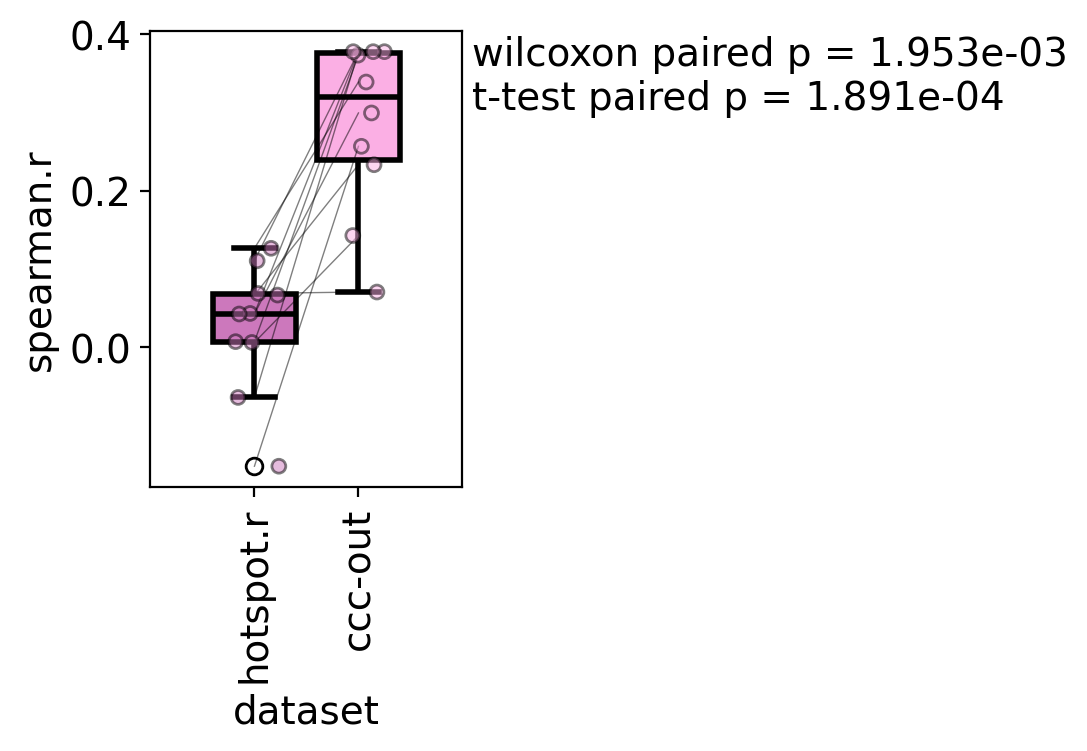

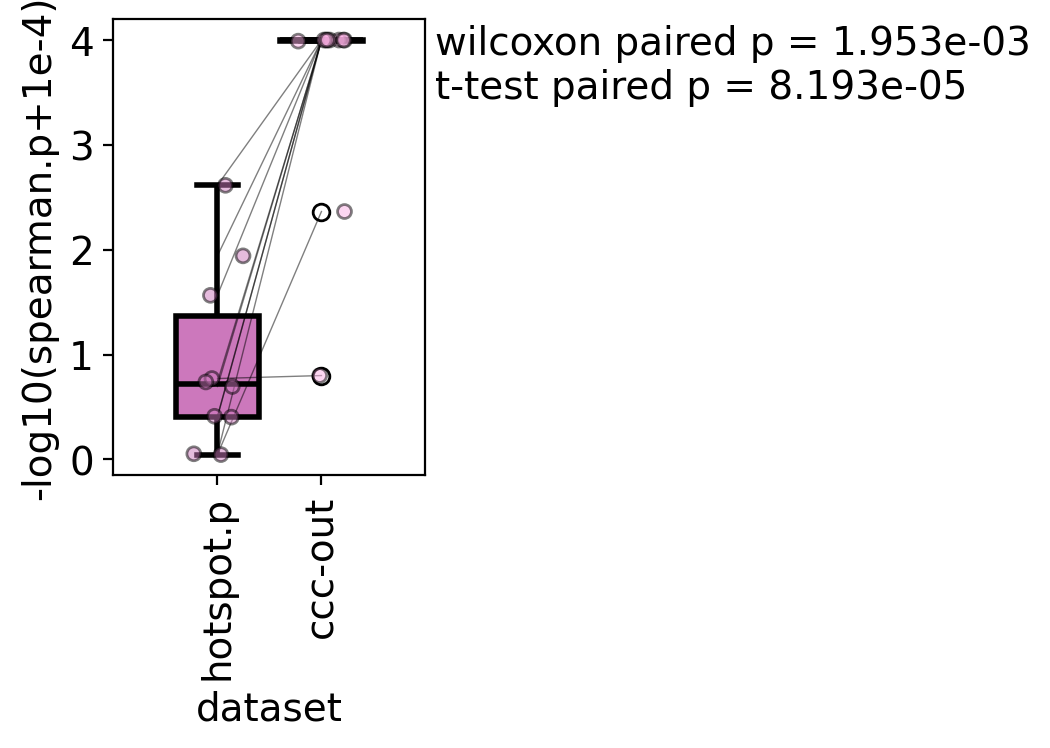

In [67]:


# run through all of the plots
for metric, value, datasets in plotters:
    # plot key pairwise metrics
    fig, ax = plt.subplots(figsize=[2, 3])
    ax.grid(False)
    ax = sns.boxplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=0,
                     saturation=1, ax=ax, order=datasets, linecolor='k', linewidth=2, palette=['#cc78bc','#fbafe4'])
    ax = sns.stripplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=2,
                       ax=ax, order=datasets, edgecolor='k', linewidth=1, jitter=0.25, alpha=0.5, palette=['#cc78bc','#fbafe4'])
    ax.tick_params(axis='x', labelrotation=90)
    if value == 'nlog10p1en4_value':
        ax.set_ylabel(f'-log10({metric}+1e-4)')
    else:
        ax.set_ylabel(f'{metric}')
    # derive the values
    x1 = data.loc[(data['metric'] == metric)&(data['dataset'] == datasets[0]), value].reset_index().iloc[:, 1]
    x2 = data.loc[(data['metric'] == metric)&(data['dataset'] == datasets[1]), value].reset_index().iloc[:, 1]
    mask = (~x1.isna()) & (~x2.isna())
    x1, x2 = x1.loc[mask], x2.loc[mask]
    for idx in x1.index:
        ax.plot(datasets, [x1.loc[idx], x2.loc[idx]], color='k', lw=0.5, alpha=0.5, zorder=1)
    # derive the p-value
    pval1 = ss.wilcoxon(x1, x2)[1]
    pval2 = ss.ttest_rel(x1, x2)[1]
    text = 'wilcoxon paired p = %.3e' % pval1
    text += '\nt-test paired p = %.3e' % pval2
    ax.text(1.03, .99, text, va='top', ha='left', transform=ax.transAxes)
    ax.set_xlim(-1, 2)

In [97]:
# let's try 25 genes and 20 simulations

import multiprocessing as mp
from tqdm import tqdm
import time
# define the parameters
n_x, n_y, n_genes = 10, 10, 25
learning_rate = 1e-1
zmft_scalar = 1e-1
epochs = 1500
# define the parameters
n_sims = 20
params_list = [[n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs] for seed in range(n_sims)]
# run the simulations
results_list = []
t0 = time.time()
for i, params in enumerate(params_list):
    print(f"simulation {i}; time passed: {time.time() - t0}")
    results = run_sim(params)
    results_list.append(results)

simulation 0; time passed: 5.364418029785156e-05
simulation 1; time passed: 119.2219705581665
simulation 2; time passed: 238.85009360313416
simulation 3; time passed: 358.73792481422424
simulation 4; time passed: 478.9817957878113
simulation 5; time passed: 598.1351537704468
simulation 6; time passed: 717.2348716259003
simulation 7; time passed: 836.5393576622009
simulation 8; time passed: 955.7894787788391
simulation 9; time passed: 1075.0545127391815
simulation 10; time passed: 1194.347981929779
simulation 11; time passed: 1314.1523268222809
simulation 12; time passed: 1433.8015913963318
simulation 13; time passed: 1553.4743888378143
simulation 14; time passed: 1672.6755421161652
simulation 15; time passed: 1791.8905103206635
simulation 16; time passed: 1911.4376089572906
simulation 17; time passed: 2030.1869404315948
simulation 18; time passed: 2149.013374567032
simulation 19; time passed: 2268.2048592567444


In [98]:
# define the order of the metrics
order = ['loss_scc','loss_ccc',
         'spearman_ccc_out_vs_scc_in.r','spearman_ccc_out_vs_scc_in.p',
         'spearman_scc_gex_corr_vs_scc_in.r','spearman_scc_gex_corr_vs_scc_in.p',
         'spearman_in_gex_corr_vs_scc_in.r','spearman_in_gex_corr_vs_scc_in.p',]
results_ccc = pd.concat([el[0] for el in results_list], axis=1).loc[order]
results_intra = pd.concat([el[1] for el in results_list], axis=1).loc[order]

In [99]:
# define the things we wish to plot
plotters = [['spearman.r', 'value', ['in-gex-corr','ccc-out']],
            ['spearman.p', 'nlog10p1en4_value', ['in-gex-corr','ccc-out']],
            ['spearman.r', 'value', ['in-gex-corr','scc-gex-corr']],
            ['spearman.p', 'nlog10p1en4_value', ['in-gex-corr','scc-gex-corr']]]

/nfs/users/nfs_s/sm58/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3134723/3718937763.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=0,
/tmp/ipykernel_3134723/3718937763.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=2,
/tmp/ipykernel_3134723/3718937763.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `

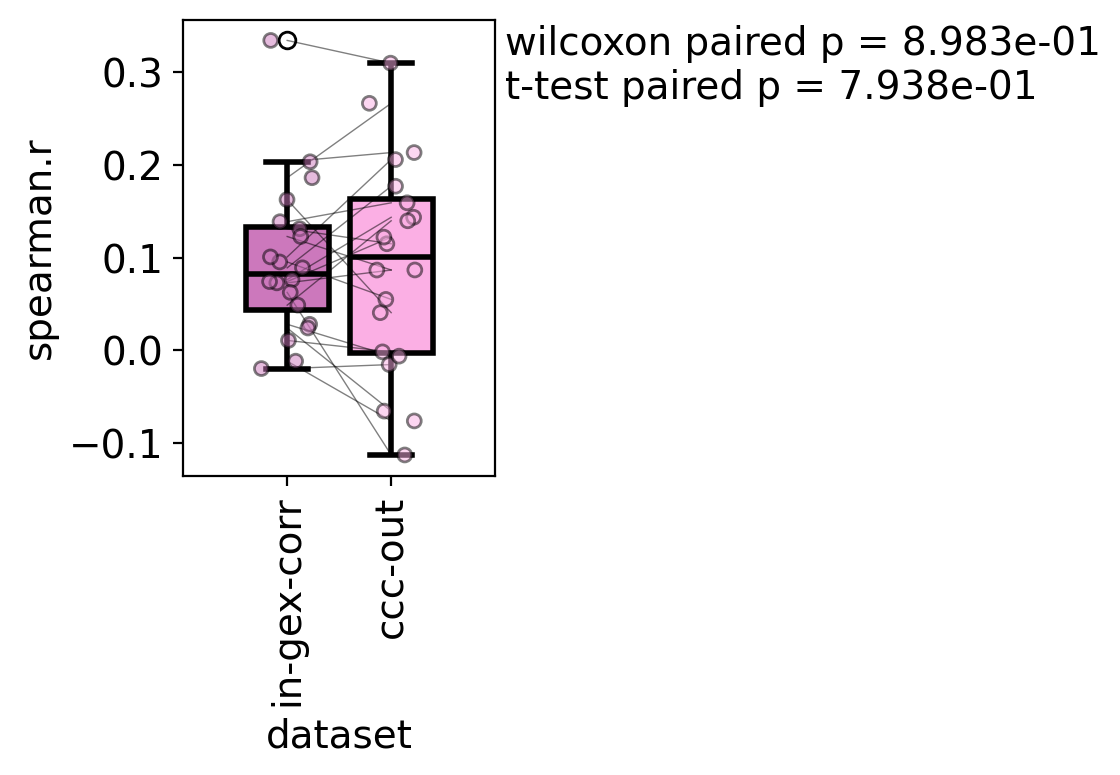

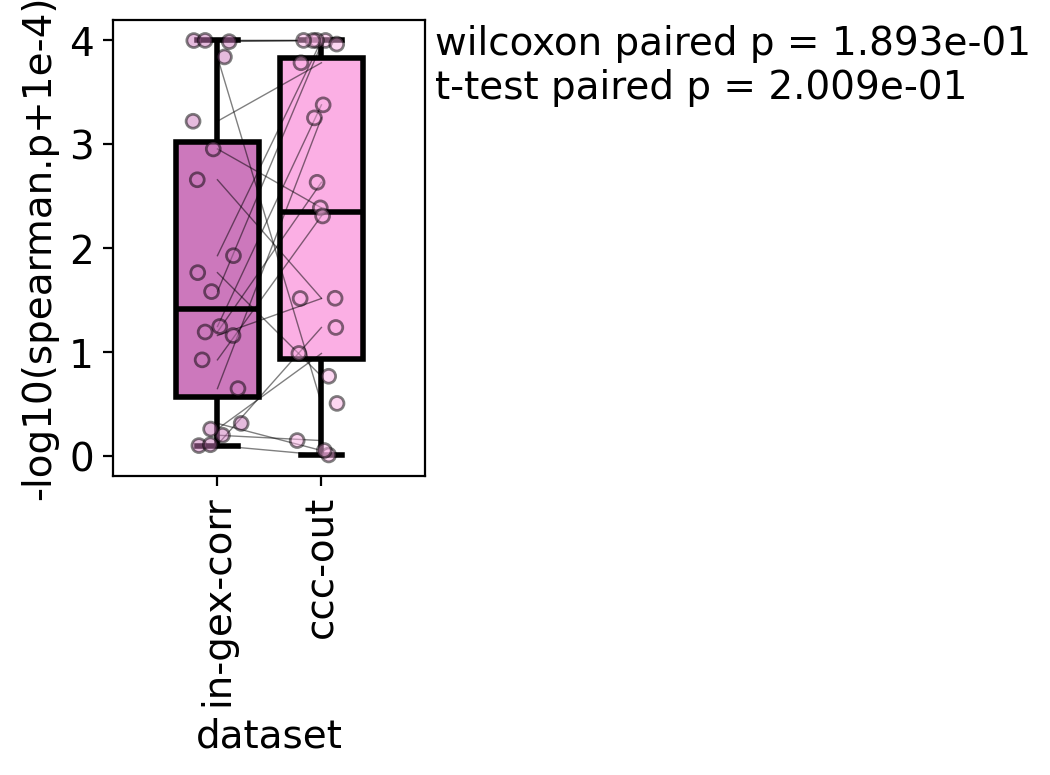

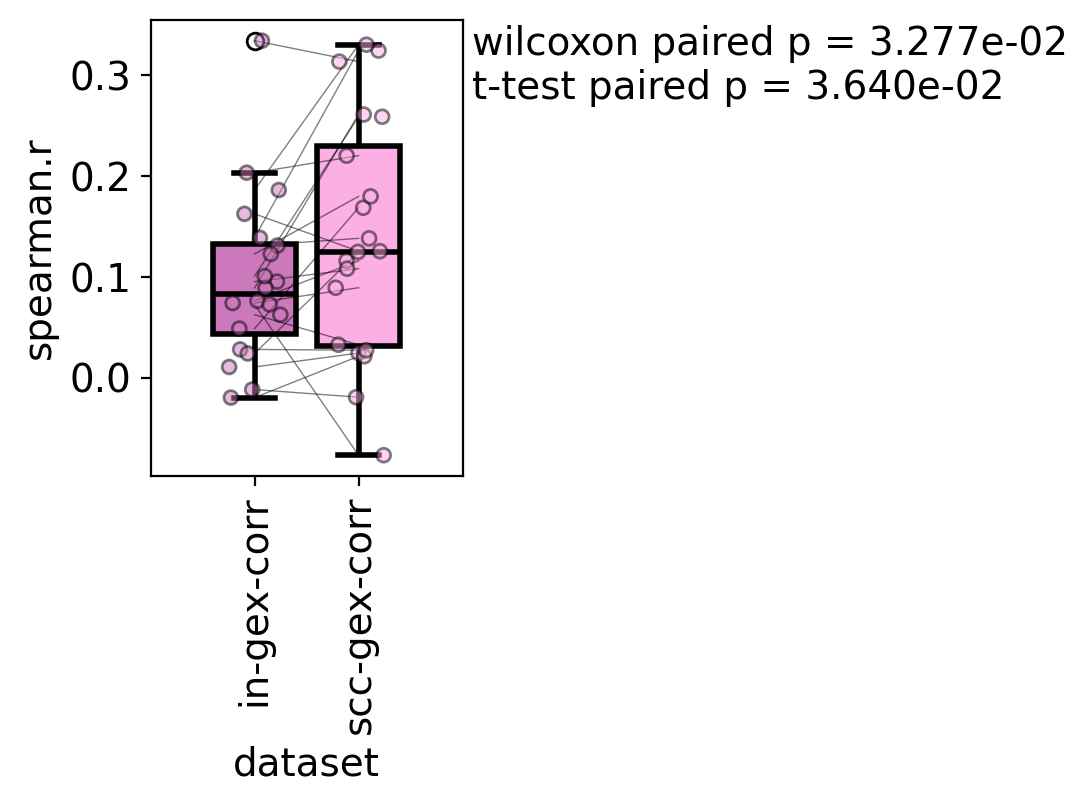

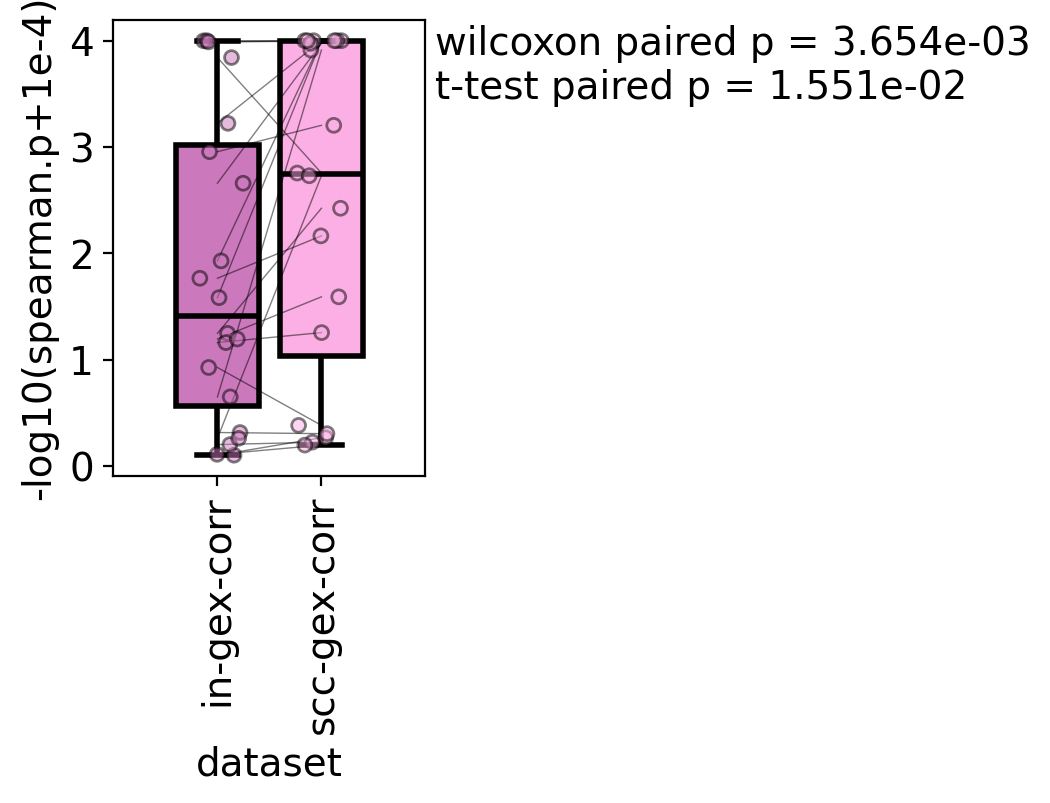

In [100]:
# melt the dataframe into a plottable function (complete this for CCC as before)
data = results_ccc.reset_index().melt(id_vars='index')
data['dataset'] = data['index'].apply(lambda x: '_'.join(x.split('_')[1:]).split('_vs_')[0]).str.replace('_','-')
data['metric'] = data['index'].apply(lambda x: x.split('_')[0]+'.'+x.split('.')[-1])
data['nlog10p1en4_value'] = -np.log10(data['value'].astype(float)+1e-4)
# run through all of the plots
for metric, value, datasets in plotters:
    # plot key pairwise metrics
    fig, ax = plt.subplots(figsize=[2, 3])
    ax.grid(False)
    ax = sns.boxplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=0,
                     saturation=1, ax=ax, order=datasets, linecolor='k', linewidth=2, palette=['#cc78bc','#fbafe4'])
    ax = sns.stripplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=2,
                       ax=ax, order=datasets, edgecolor='k', linewidth=1, jitter=0.25, alpha=0.5, palette=['#cc78bc','#fbafe4'])
    ax.tick_params(axis='x', labelrotation=90)
    if value == 'nlog10p1en4_value':
        ax.set_ylabel(f'-log10({metric}+1e-4)')
    else:
        ax.set_ylabel(f'{metric}')
    # derive the values
    x1 = data.loc[(data['metric'] == metric)&(data['dataset'] == datasets[0]), value].reset_index().iloc[:, 1]
    x2 = data.loc[(data['metric'] == metric)&(data['dataset'] == datasets[1]), value].reset_index().iloc[:, 1]
    mask = (~x1.isna()) & (~x2.isna())
    x1, x2 = x1.loc[mask], x2.loc[mask]
    for idx in x1.index:
        ax.plot(datasets, [x1.loc[idx], x2.loc[idx]], color='k', lw=0.5, alpha=0.5, zorder=1)
    # derive the p-value
    pval1 = ss.wilcoxon(x1, x2)[1]
    pval2 = ss.ttest_rel(x1, x2)[1]
    text = 'wilcoxon paired p = %.3e' % pval1
    text += '\nt-test paired p = %.3e' % pval2
    ax.text(1.03, .99, text, va='top', ha='left', transform=ax.transAxes)
    ax.set_xlim(-1, 2)